In [10]:
import data_setup_ood
import torch
import matplotlib.pyplot as plt
import torchvision
import numpy as np

device = "cpu"

weights = torchvision.models.DenseNet121_Weights.DEFAULT
model = torchvision.models.densenet121(weights=weights).to(device)
auto_transform = weights.transforms()


model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features = 1024, out_features = 9)
)

def show_image(img_tensor, title=None):
    """
    Display a tensor as an image.
    
    Parameters:
    - img_tensor (torch.Tensor): The image tensor in CHW format.
    - title (str): Optional title for the image.
    """
    # Convert the tensor to HWC format and then to a NumPy array
    img = img_tensor.permute(1, 2, 0).numpy()
    
    # If the image has 1 channel, convert it to 3 channels by repeating the image
    if img.shape[2] == 1:
        img = np.repeat(img, 3, axis=2)
    
    # Display the image
    plt.figure()
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [11]:
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [12]:
%load_ext autoreload
%autoreload 2

In [13]:
import data_setup_ood_dark
import torchvision

f = data_setup_ood_dark.create_dataloaders(
    auto_transform,
)

(img, label) = next(iter(f[0][6]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


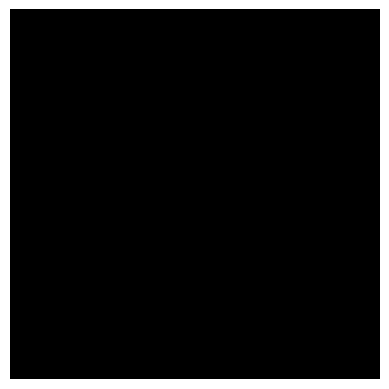

In [14]:
image = img[12]
show_image(image)

## Let's start from the beginning

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import torch
import torchvision
import numpy as np
from pathlib import Path
import copy
from tqdm.auto import tqdm

In [17]:
seed = 42
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def createSamples(updates, gen):
    num_updates = 5000
    random_vectors = gen.normal(0, 1, (num_updates, updates.shape[1]))
    return (np.expand_dims(updates, 0) + np.expand_dims(random_vectors, 1)).reshape(-1, updates.shape[1])

In [18]:
root_dir = "../10-client-1-server-10/models"
distribution_clients = [0,1,2,3,4]
test_clients = [0,1,2,3,4,5,6,7]
epochs = 10
seed = 42
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

class MahalanobisDistance:
    def __init__(self):
        self.path = Path(root_dir)
        self.distribution_clients = distribution_clients
        self.test_clients = test_clients
        self.server_path = self.path/"server"
        self.client_paths = [self.path/f"client-{i}" for i in sorted(list(set(distribution_clients + test_clients)))]
        self.epochs = 5
        self.device = device
        self.gen = np.random.default_rng(seed=seed)

    def createSamples(self, updates):
        num_updates = 5000
        random_vectors = 0.1*torch.normal(0, 1, (num_updates, updates.shape[1])).to(self.device)
        return (torch.unsqueeze(updates, 0) + torch.unsqueeze(random_vectors, 1)).reshape(-1, updates.shape[1])

    def calculate_mahalanobis_distance(self):
        fin_mahal_dis = []
        flatten_layer = torch.nn.Flatten(start_dim=0)
        
        for epoch in range(1, self.epochs):
            mahal_dis = {}
            for i in self.test_clients:
                mahal_dis[i] = []
            client_models = [torch.load(self.client_paths[i]/f"epoch-{epoch}.pt", map_location='cpu') for i in range(len(self.client_paths))]            
            prev_server_model = torch.load(self.server_path/f"epoch-{epoch-1}.pt", map_location='cpu')
            for (key, value) in prev_server_model.items():
                for i in range(len(client_models)):
                    client_models[i][key] = client_models[i][key] - prev_server_model[key]
        
            for (key, value) in tqdm(prev_server_model.items(), ncols = 0):
                    # print(value.shape)
                    # idx += 1
                    # if(idx > 20):
                    #     break
                    # continue
                # try:
                    torch.cuda.empty_cache()
                    if(value.shape == torch.Size([])):
                        continue
                    
                    data = np.array([flatten_layer(client_models[i][key]).numpy() for i in self.distribution_clients])
                    # data = torch.tensor(data).to(device)
                    # return data
                    data = torch.tensor(data, dtype = torch.float64).to(device)
                    return data
                    data = self.createSamples(data)
                    y_mu = torch.mean(data, axis = 0)
                    
                    
                    cov = torch.cov(data.T)
                    del data
                    torch.cuda.empty_cache()

                    L = torch.linalg.cholesky(cov)
                    
                    del cov
                    torch.cuda.empty_cache()

                    test_data = np.array([flatten_layer(client_models[i][key]).numpy() for i in self.test_clients], dtype = np.float64)
                    test_data = torch.tensor(test_data).to(self.device)
                    test_data = (test_data - y_mu.unsqueeze(0)).to(device)

                    torch.cuda.empty_cache()
                    

                    mdis = torch.linalg.solve(L, test_data.T)
                    
                    mdis = torch.linalg.norm(mdis, dim = 0)
                    break
                    idx = 0
                    for i in range(len(self.test_clients)):
                        mahal_dis[self.test_clients[i]].append(mdis[i])

                # except:
                #     return False
                #     continue
                
            break

    

In [19]:
m = MahalanobisDistance()
data = m.calculate_mahalanobis_distance()

  0% 0/727 [00:00<?, ?it/s]

In [20]:
def createSamples(updates):
    num_updates = 10000
    random_vectors = torch.tensor(0.01*np.random.multivariate_normal(torch.mean(updates, dim=0).cpu().numpy(), torch.diag(torch.var(updates, dim = 0)).cpu().numpy(), num_updates)).to(device)
    return (torch.unsqueeze(updates, 0) + torch.unsqueeze(random_vectors, 1)).reshape(-1, (updates.shape[1]))


In [21]:
gen = np.random.default_rng(seed=seed)
def createSamples(updates):
    num_updates = 5000
    cov = torch.cov(updates.T).cpu().numpy()
    random_vectors = 0.001*torch.tensor(np.random.multivariate_normal(np.zeros(updates.shape[1]), cov, (num_updates, updates.shape[1])), dtype = torch.float64).to(device)
    return (torch.unsqueeze(updates, 0) + torch.unsqueeze(random_vectors, 1)).reshape(-1, updates.shape[1])

In [22]:
for key in client_models[0].keys():
    if "conv" in key:
        print(key)

NameError: name 'client_models' is not defined

## Playing

In [ ]:
import torch
import torchvision
import os
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

root_dir = "../10-client-1-server-10-ood-2-untrained-Adam/models"
path = Path(root_dir)
client_paths = [path/f"client-{i}" for i in range(8)]
server_path = path/"server"
distribution_clients = [0,1,2,3,4,5,6,7]
test_clients = [0,1,2,3,4,5,6,7]
server_path = path/"server"
_,_,files = next(os.walk(client_paths[0]))
num_epochs = len(files)
device1 = "cuda:0" if torch.cuda.is_available() else 'cpu'
device2 = "cuda:0" if torch.cuda.is_available() else 'cpu'



class MahalanobisDistance:
    def __init__(self, device1, device2):
        self.device1 = device1
        self.device2 = device2

    def _mahalanobis(self, x_test, x_mean, cov, device):
        cov2 = cov.to(device)
        L = torch.linalg.cholesky(cov2)
        test_data = ((x_test - x_mean.unsqueeze(0))).to(device)
        mdis = torch.linalg.solve(L, test_data.T)
        return torch.linalg.norm(mdis, dim=0)
    
    def _mahalanobis_approx(self, x_test, x_mean, cov, device):
        cov2 = cov.to(device)
        test_data = ((x_test - x_mean.unsqueeze(0))).to(device)
        return torch.mm(test_data, torch.mm(torch.linalg.pinv(cov2), test_data.T))

    def mahalanobis(self, train_data, test_data):
        train_data = train_data.to(self.device1)
        test_data = test_data.to(self.device1)
        train_mean = torch.mean(train_data, dim=0)
        train_cov = torch.cov(train_data.T)
        return self._mahalanobis(test_data, train_mean, train_cov, self.device2)
    
    def mahalanobis_approx(self, train_data, test_data):
        train_data = train_data.to(self.device1)
        test_data = test_data.to(self.device1)
        train_mean = torch.mean(train_data, dim=0)
        train_cov = torch.cov(train_data.T)
        return self._mahalanobis_approx(test_data, train_mean, train_cov, self.device2)
    
    def pca_transform(self, train_data, test_data, percent_variation):
        if torch.is_tensor(train_data):
            train_data = train_data.to('cpu').numpy()
        if torch.is_tensor(test_data):
            test_data = test_data.to('cpu').numpy()

        scalar = StandardScaler()
        scalar.fit(train_data)
        train_data = scalar.transform(train_data)
        test_data = scalar.transform(test_data)

        pca = PCA(percent_variation)
        pca.fit(train_data)
        train_data = pca.transform(train_data)
        test_data = pca.transform(test_data)

        train_data = torch.tensor(train_data).to(self.device1)
        test_data = torch.tensor(test_data).to(self.device2)

        return train_data, test_data, pca

In [ ]:
import torch
from pathlib import Path

root_dir = "../10-client-1-server-10-ood-2-untrained-Adam/models"
path = Path(root_dir)
client_paths = [path/f"client-{i}" for i in range(8)]
server_path = path/"server"
distribution_clients = [0,1,2,3,4]
test_clients = [0,1,2,3,4,5,6,7]
server_path = path/"server"
_,_,files = next(os.walk(client_paths[0]))
num_epochs = len(files)
device1 = "cuda:0" if torch.cuda.is_available() else 'cpu'
device2 = "cuda:0" if torch.cuda.is_available() else 'cpu'
pca_percent_variation = 0.95

# epoch = 1
# client_models = [torch.load(client_paths[i]/f"epoch-{epoch}.pt", map_location='cpu') for i in range(len(client_paths))]            
# prev_server_model = torch.load(server_path/f"epoch-{epoch-1}.pt", map_location='cpu')

# keys = list(prev_server_model.keys())

# key = keys[0]

# for i in range(len(client_models)):
#     client_models[i][key] = client_models[i][key] - prev_server_model[key]

In [ ]:
fin_mahal = {}
for epoch in range(1, num_epochs):
    client_models = [torch.load(client_paths[i]/f"epoch-{epoch}.pt", map_location='cpu') for i in range(len(client_paths))]            
    prev_server_model = torch.load(server_path/f"epoch-{epoch-1}.pt", map_location='cpu')
    keys = list(prev_server_model.keys())

    mahal_dis = {}
    for key in keys:
        if "conv" not in key:
            continue
        mahal_dis[key] = {}

        for i in range(len(client_models)):
            client_models[i][key] = client_models[i][key] - prev_server_model[key]

        train_data, test_data = [], []

        
        num_samples_per_client = client_models[0][key].shape[0]
        
        for i in distribution_clients:
            train_data.extend(client_models[i][key].numpy())

        for i in test_clients:
            test_data.extend(client_models[i][key].numpy())
            
        
                
        train_data = np.array(train_data).astype(np.float64)
        test_data = np.array(test_data).astype(np.float64)
        
        
        train_data = train_data.reshape(train_data.shape[0], -1)
        test_data = test_data.reshape(test_data.shape[0], -1)
        # print(train_data.shape, end = " ")
        m = MahalanobisDistance(device1, device2)

        train_data, test_data, pca = m.pca_transform(train_data=train_data, test_data=test_data, percent_variation=pca_percent_variation)
        # print(pca.n_components_)
        mahal = m.mahalanobis(train_data, test_data)

        for i in range(len(test_clients)):
            client = test_clients[i]
            mahal_dis[key][client] = torch.sum(mahal[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
    fin_mahal[epoch] = mahal_dis
    

In [ ]:
import torch
torch.sum(torch.tensor([1,2,3])).item()

6

In [ ]:
device1 = "cuda:0" if torch.cuda.is_available() else 'cpu'

In [ ]:
keys = list(client_models[0].keys())
flat = torch.nn.Flatten(start_dim=1)

In [ ]:
client_models[0][keys[0]].shape

torch.Size([64, 3, 7, 7])

In [ ]:
data = []
test_data = []

layer = 1

for i in distribution_clients:
    data.extend(client_models[i][keys[0]].numpy())

for i in test_clients:
    test_data.extend(client_models[i][keys[0]].numpy())

data = np.array(data).astype(np.float64)
test_data = np.array(test_data).astype(np.float64)
data = data.reshape(data.shape[0], -1)
test_data = test_data.reshape(test_data.shape[0], -1)

In [ ]:
# data = torch.tensor(data).to(device1)
# test_data = torch.tensor(test_data).to(device1)

In [ ]:
# PCA analysis
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)
test_data = scaler.transform(test_data)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(.95)

pca.fit(data)

PCA(n_components=0.95)

In [ ]:
pca.explained_variance_ratio_

array([0.36838302, 0.17556633, 0.14829598, 0.09519218, 0.05070259,
       0.02963631, 0.02423131, 0.01897894, 0.01515474, 0.01457732,
       0.01416871])

In [ ]:
data = pca.transform(data)
test_data = pca.transform(test_data)

In [ ]:
data = torch.tensor(data).to(device1)
test_data = torch.tensor(test_data).to(device1)

In [ ]:
m = MahalanobisDistance(device1, device1)
train_data, test_data, pca = m.pca_transform(data, test_data, 0.8)
mahal = m.mahalanobis(train_data, test_data)

In [ ]:
pca.explained_variance_ratio_

array([0.41294663, 0.12240628, 0.08814559, 0.08602628, 0.05180375,
       0.03963071])

In [ ]:
ans = []
num_clients = mahal.shape[0]/64
for i in range(0, mahal.shape[0], 64):
    ans.append(torch.sum(mahal[i:i+64])/64)

In [ ]:
ans

[tensor(2.3746, device='cuda:0', dtype=torch.float64),
 tensor(2.1918, device='cuda:0', dtype=torch.float64),
 tensor(2.2748, device='cuda:0', dtype=torch.float64),
 tensor(2.6939, device='cuda:0', dtype=torch.float64),
 tensor(2.2866, device='cuda:0', dtype=torch.float64),
 tensor(2.3901, device='cuda:0', dtype=torch.float64),
 tensor(3.3244, device='cuda:0', dtype=torch.float64),
 tensor(3.4149, device='cuda:0', dtype=torch.float64)]

In [ ]:
mahal.shape

torch.Size([512])

# Using RGB analysis

In [ ]:
import torchsummary
import torchvision

weights = torchvision.models.DenseNet121_Weights.DEFAULT
model = torchvision.models.densenet121(weights=weights).to('cpu')
auto_transform = weights.transforms()


model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features = 1024, out_features = 9)
)

torchsummary.summary(model)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─_DenseBlock: 2-5                  --
|    |    └─_DenseLayer: 3-1             45,440
|    |    └─_DenseLayer: 3-2             49,600
|    |    └─_DenseLayer: 3-3             53,760
|    |    └─_DenseLayer: 3-4             57,920
|    |    └─_DenseLayer: 3-5             62,080
|    |    └─_DenseLayer: 3-6             66,240
|    └─_Transition: 2-6                  --
|    |    └─BatchNorm2d: 3-7             512
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  32,768
|    |    └─AvgPool2d: 3-10              --
|    └─_DenseBlock: 2-7                  --
|    |    └─_DenseLayer: 3-11            53,760
|    |    └─_DenseLayer: 3-12            57,920
|    |    └─_DenseLayer: 3-13 

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─_DenseBlock: 2-5                  --
|    |    └─_DenseLayer: 3-1             45,440
|    |    └─_DenseLayer: 3-2             49,600
|    |    └─_DenseLayer: 3-3             53,760
|    |    └─_DenseLayer: 3-4             57,920
|    |    └─_DenseLayer: 3-5             62,080
|    |    └─_DenseLayer: 3-6             66,240
|    └─_Transition: 2-6                  --
|    |    └─BatchNorm2d: 3-7             512
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  32,768
|    |    └─AvgPool2d: 3-10              --
|    └─_DenseBlock: 2-7                  --
|    |    └─_DenseLayer: 3-11            53,760
|    |    └─_DenseLayer: 3-12            57,920
|    |    └─_DenseLayer: 3-13 

In [ ]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
conv = [module for module in model.modules() if isinstance(module, torch.nn.Conv2d)]

In [ ]:
for module_name, module in model.named_modules():
    
    if isinstance(module, torch.nn.Conv2d):
        print(f"Name: {module_name} | Module: {module}")

Name: features.conv0 | Module: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Name: features.denseblock1.denselayer1.conv1 | Module: Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Name: features.denseblock1.denselayer1.conv2 | Module: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Name: features.denseblock1.denselayer2.conv1 | Module: Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Name: features.denseblock1.denselayer2.conv2 | Module: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Name: features.denseblock1.denselayer3.conv1 | Module: Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Name: features.denseblock1.denselayer3.conv2 | Module: Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Name: features.denseblock1.denselayer4.conv1 | Module: Conv2d(160, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Name: features.d

In [ ]:
keys[-3]

'features.norm5.num_batches_tracked'

In [ ]:
from pathlib import  Path
import torch
mdis = torch.load(Path("../10-client-1-server-10-ood-2-untrained-Adam/mahal_dis.pt"), map_location="cpu")

In [ ]:
mdis[6]

{'features.conv0.weight': {0: 3.4729968321388496,
  1: 3.514791367924788,
  2: 3.5338084336591726,
  3: 3.56563776561096,
  4: 3.653152254806872,
  5: 3.5504473816693074,
  6: 3.973591615829212,
  7: 4.037373521712014},
 'features.denseblock1.denselayer1.conv1.weight': {0: 6.548987664883368,
  1: 6.096402602392493,
  2: 6.170915930238845,
  3: 7.006627006218181,
  4: 7.00962792085236,
  5: 7.44630985187411,
  6: 7.683012263979218,
  7: 7.347235393278635},
 'features.denseblock1.denselayer1.conv2.weight': {0: 9.081084732024765,
  1: 8.488135793106537,
  2: 8.38410918995389,
  3: 8.847143806463967,
  4: 8.87612596576324,
  5: 6.945934134962079,
  6: 7.884219561017379,
  7: 7.743812735045318},
 'features.denseblock1.denselayer2.conv1.weight': {0: 8.070890660705379,
  1: 7.483987499049439,
  2: 7.309732386160158,
  3: 8.19004601026398,
  4: 8.333855287454336,
  5: 9.059243456808824,
  6: 9.171781522040707,
  7: 9.101428639285826},
 'features.denseblock1.denselayer2.conv2.weight': {0: 7.780

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [ ]:
for i in range(1, 10):
    l = [0 for i in range(0,10)]
    for (key, value) in mdis[i].items():
        for j in range(8):
            l[j] += mdis[i][key][j]
    print(torch.tensor(l[-5:-2])/len(mdis[i].items()))
        

tensor([20.5293, 63.1580, 37.8344])
tensor([ 429309.4375,   16477.2207, 1501150.6250])
tensor([52834.6758, 18133.0449, 61562.1680])
tensor([   236.8094, 165841.4531,   4726.7300])
tensor([  3572.2146,  37024.3398, 411224.1562])
tensor([  11192.8086, 4139610.5000,   45549.1953])
tensor([ 10137.6455, 167508.5781, 408608.5000])
tensor([1.3296e+04, 1.4646e+07, 2.8690e+04])
tensor([  30344.3379, 2264521.0000, 2355315.7500])


## ANA

In [1]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ana-75-untrained-Adam/mahal_dis_all_distribution_inchannelwise.pt")
mahal_dis = torch.load(path, map_location='cpu')

In [2]:
for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 75.16185508024203, 1: 84.37860069473136, 2: 74.93034375668842, 3: 78.14253750598199, 4: 88.92289516698355, 5: 90.00834791480801, 6: 372.01007726947233, 7: 382.6939101273342}
{0: 79.6047327808241, 1: 79.70779236034657, 2: 89.59423118641753, 3: 77.21992911718937, 4: 91.04735132448515, 5: 89.89271646481531, 6: 376.0927311959221, 7: 364.4716996522267}
{0: 81.11814251303937, 1: 77.80446842134238, 2: 86.44035201256472, 3: 85.93331980401554, 4: 78.88393041142798, 5: 92.68349304924973, 6: 371.7521559038591, 7: 368.7275458086276}
{0: 85.41357151203806, 1: 88.12601854267358, 2: 90.17159522184167, 3: 88.60495075803976, 4: 90.21200277026762, 5: 93.29869658544338, 6: 367.1960238886019, 7: 364.0191676338134}
{0: 86.34458755710568, 1: 82.71023072376734, 2: 86.31628444416403, 3: 84.98543944757243, 4: 84.0677266936249, 5: 84.05475127066073, 6: 369.113523158293, 7: 367.77564294926196}
{0: 84.32019029952103, 1: 81.41416938206712, 2: 83.3151667208518, 3: 82.26697344747144, 4: 83.02535316396605, 5: 80.

In [3]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ana-75-untrained-Adam/euclid_dis_all_distribution_inchannelwise.pt")
euclid_dis = torch.load(path, map_location='cpu')

In [4]:
for epoch in range(1, len(euclid_dis)):
    ans = {}
    for(key, value) in euclid_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 2.875043619133319, 1: 2.9749309126371797, 2: 2.8577757518578175, 3: 2.9006295111569553, 4: 3.0755212257592723, 5: 3.0805539288255432, 6: 4.907635363293983, 7: 5.045803069192926}
{0: 2.9774190323311065, 1: 2.9959929662565563, 2: 3.101777393342236, 3: 2.9288893407455743, 4: 3.116209414099027, 5: 3.0746673603191255, 6: 5.23778345784097, 7: 5.102645088800972}
{0: 2.7604542054860617, 1: 2.713910211885727, 2: 2.801087416909668, 3: 2.806452776240057, 4: 2.735000137310516, 5: 2.8651410397136803, 6: 5.295696404026813, 7: 5.234183808162546}
{0: 2.8332480551755275, 1: 2.8534659902783406, 2: 2.871557024545641, 3: 2.8641746216664914, 4: 2.868851327773846, 5: 2.910809884900143, 6: 5.649691162863237, 7: 5.591704755473854}
{0: 2.8484995729313196, 1: 2.800210668189465, 2: 2.846919039201955, 3: 2.8198658425829337, 4: 2.81128873562696, 5: 2.8175719644345065, 6: 5.852975773336143, 7: 5.835033716083221}
{0: 2.8805680732730283, 1: 2.8437904712135422, 2: 2.8622661838076047, 3: 2.8555360037259003, 4: 2.85

In [10]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ana-75-untrained-Adam/mahal_dis_all_pca.pt")
mahal_dis = torch.load(path, map_location='cpu')

for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        if 'conv' in key:
            continue
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

print()
for epoch in range(1, len(mahal_dis)):
    print(list(mahal_dis[epoch].items())[-2:])

{0: 890.7220084118044, 1: 889.2813472114204, 2: 891.9754653270878, 3: 892.093832900978, 4: 889.9288585017813, 5: 886.5679531683993, 6: 2085.3056881895227, 7: 2098.227641718202}
{0: 889.50642302922, 1: 891.4535047520764, 2: 894.6113904132864, 3: 885.6708958783311, 4: 892.2354600573127, 5: 888.6107412270143, 6: 2106.0333513007295, 7: 2089.4686164024865}
{0: 877.3061120373313, 1: 880.3896133126411, 2: 879.5424827845619, 3: 876.524266138975, 4: 876.2205333792085, 5: 879.0291444204016, 6: 2094.882165689606, 7: 2122.7813684634402}
{0: 892.0463867244382, 1: 888.298831674752, 2: 884.853821439631, 3: 884.3074826481076, 4: 887.2854676730304, 5: 888.4663625889816, 6: 2123.7122761899727, 7: 2093.3326706379908}
{0: 883.9438584470656, 1: 889.5429489930099, 2: 884.2768400423525, 3: 885.6580580215847, 4: 881.0082623957464, 5: 881.2331828860292, 6: 2121.769116243535, 7: 2083.580826065609}
{0: 883.6899341729976, 1: 887.7723271762121, 2: 880.2764429605568, 3: 883.535083821481, 4: 882.3874887357315, 5: 87

## OOD


In [ ]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-untrained-Adam/mahal_dis_all_distribution_inchannelwise.pt")
mahal_dis = torch.load(path, map_location='cpu')

In [ ]:
for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 161.84589020070587, 1: 159.16889041484518, 2: 177.84866203272452, 3: 175.67423500670415, 4: 166.82946032002258, 5: 158.37698964633347, 6: 145.24634272861957, 7: 164.4229588457847}
{0: 141.19037676444572, 1: 173.5263643988298, 2: 144.9402837405289, 3: 173.94119101059698, 4: 155.68181279263246, 5: 138.31343552490966, 6: 152.42605862495088, 7: 162.63822801743132}
{0: 143.38101617130224, 1: 137.98549527005838, 2: 145.07990055604463, 3: 141.71979000516413, 4: 141.49465974970562, 5: 146.19265154403348, 6: 201.5035815639893, 7: 221.0868342568707}
{0: 159.35041401082472, 1: 156.243381421156, 2: 149.89620831852855, 3: 165.37234161083867, 4: 162.4658310542654, 5: 168.03185286821267, 6: 190.2546175460392, 7: 182.1843400270168}
{0: 168.46127613940646, 1: 166.39157406225985, 2: 172.00690489752262, 3: 166.4817716840979, 4: 162.3995540292102, 5: 174.74795218508396, 6: 167.56424450364366, 7: 170.0483684634043}
{0: 180.67055004015268, 1: 159.83560621135, 2: 165.89783418994207, 3: 179.21294077535453

In [7]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-untrained-Adam/euclid_dis_all_distribution_inchannelwise.pt")
euclid_dis = torch.load(path, map_location='cpu')

In [8]:
for epoch in range(1, len(euclid_dis)):
    ans = {}
    for(key, value) in euclid_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 2.308233992925305, 1: 2.311433793839788, 2: 2.3582109326185763, 3: 2.3480366200106, 4: 2.2783435960931153, 5: 2.2615844316670963, 6: 2.1943129855799053, 7: 2.321722995970608}
{0: 2.001275385229512, 1: 2.134215687942112, 2: 2.0443986712510034, 3: 2.1532039027144063, 4: 2.07560670730884, 5: 2.0258119644622634, 6: 2.054372797732554, 7: 2.0722746106490315}
{0: 1.9786768985978775, 1: 1.971677254185075, 2: 1.973567770326478, 3: 1.9605935169753548, 4: 1.975888615974931, 5: 1.962963475111127, 6: 2.1766464413311697, 7: 2.274799942385151}
{0: 1.7161205946792821, 1: 1.7313396195490394, 2: 1.6925009065201115, 3: 1.7583531612541443, 4: 1.7339949173459037, 5: 1.7678446700105, 6: 1.9321454946308705, 7: 1.930045480235006}
{0: 1.674656938657372, 1: 1.6840787396479058, 2: 1.6719359384693637, 3: 1.666867562253684, 4: 1.656690066241034, 5: 1.7095227975761784, 6: 1.719354980842131, 7: 1.7382447146179816}
{0: 1.6684242595336027, 1: 1.6040221056085502, 2: 1.607136835283661, 3: 1.6607751180588484, 4: 1.59

In [11]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-untrained-Adam/mahal_dis_all_pca.pt")
mahal_dis = torch.load(path, map_location='cpu')

for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        if 'conv' in key:
            continue
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

print()
for epoch in range(1, len(mahal_dis)):
    print(list(mahal_dis[epoch].items())[-2:])

{0: 657.1215901237292, 1: 647.869796080227, 2: 641.7848564424459, 3: 642.5720900309465, 4: 639.9457788412017, 5: 637.7151330667868, 6: 644.0426514713712, 7: 638.241987532901}
{0: 642.6022452632576, 1: 658.2433350201846, 2: 634.1496733083146, 3: 644.5854630386226, 4: 638.4538007207015, 5: 641.9422851039835, 6: 642.0245414415004, 7: 647.1482503726158}
{0: 643.5327088893829, 1: 637.6150913265617, 2: 634.2047893947223, 3: 634.9882661507722, 4: 632.7099920980122, 5: 630.8104924532635, 6: 670.2222746653952, 7: 664.2464983084271}
{0: 642.9112604517032, 1: 637.9744387337163, 2: 640.6280056433544, 3: 641.865766559264, 4: 636.3547951672713, 5: 634.3986446592257, 6: 658.6816873816177, 7: 656.378118748776}
{0: 646.7295042591455, 1: 645.4213465645557, 2: 642.5072249065933, 3: 635.915232799858, 4: 637.9471635459728, 5: 633.7176270888347, 6: 653.2567844270678, 7: 653.2302634656774}
{0: 655.1909729617348, 1: 643.6267846565052, 2: 647.3070261837822, 3: 643.0871136469631, 4: 632.8051730184336, 5: 636.69

## OOD Dark

In [9]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-dark-untrained-Adam/mahal_dis_all_distribution_inchannelwise.pt")
mahal_dis = torch.load(path, map_location='cpu')

In [10]:
for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 160.55205887056934, 1: 156.92490040525007, 2: 163.9737539426774, 3: 147.1501243807301, 4: 164.55251893671584, 5: 172.02318244712444, 6: 135.69324701605777, 7: 191.65602625166753}
{0: 163.6028698143785, 1: 162.42296249684279, 2: 151.18076477281508, 3: 145.577552624353, 4: 133.13916805379316, 5: 142.74386727898494, 6: 145.8711544248254, 7: 202.27050474774268}
{0: 193.2663994073921, 1: 165.8087700157188, 2: 175.8035767825257, 3: 164.0047357891837, 4: 177.69027755856666, 5: 147.66093338194793, 6: 155.34143154912735, 7: 135.89147252128285}
{0: 163.85850653337175, 1: 161.24186968888804, 2: 167.60736060777663, 3: 178.33376404870288, 4: 166.8653726217556, 5: 171.81229877595146, 6: 152.12517386454462, 7: 160.1400609004818}
{0: 160.93477412571835, 1: 157.77662083587106, 2: 174.28670952387358, 3: 180.71455684132883, 4: 172.32359641552364, 5: 161.79220075225288, 6: 144.7465124689838, 7: 149.8754512049921}
{0: 163.2517316619147, 1: 166.33945692179276, 2: 179.5709828241833, 3: 163.5099299190839,

In [11]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-dark-untrained-Adam/euclid_dis_all_distribution_inchannelwise.pt")
euclid_dis = torch.load(path, map_location='cpu')

In [12]:
for epoch in range(1, len(euclid_dis)):
    ans = {}
    for(key, value) in euclid_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 2.400475877352795, 1: 2.279242804603996, 2: 2.3559732903088038, 3: 2.3016857476125376, 4: 2.419424963767198, 5: 2.4253574515753322, 6: 2.1505159383769628, 7: 2.25703472216403}
{0: 2.109165945151342, 1: 2.1085370024307077, 2: 2.170455742462612, 3: 2.0610446114057743, 4: 2.0429569783926373, 5: 2.0897661635766025, 6: 2.0454621301899163, 7: 2.1943630431012724}
{0: 2.2738476794892035, 1: 2.1954820337711127, 2: 2.2207250279631117, 3: 2.1182375503828923, 4: 2.2072401318851465, 5: 2.0768775395981693, 6: 2.1513816662816483, 7: 2.0682822424893232}
{0: 1.8951831093237377, 1: 1.8799275997659153, 2: 1.9324104605699015, 3: 1.9362067784686214, 4: 1.9366773442168503, 5: 1.932053905972487, 6: 1.9405387118959876, 7: 1.9929713506106423}
{0: 1.797472034696236, 1: 1.8216391595974393, 2: 1.8586511992414574, 3: 1.8685497013566006, 4: 1.8463157158991879, 5: 1.8279411921871733, 6: 1.8351327730186235, 7: 1.839142103788324}
{0: 1.8037803697541905, 1: 1.8037860340068652, 2: 1.8373156856192439, 3: 1.8060198212

In [12]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-dark-untrained-Adam/mahal_dis_all_pca.pt")
mahal_dis = torch.load(path, map_location='cpu')

for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        if 'conv' in key:
            continue
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

print()
for epoch in range(1, len(mahal_dis)):
    print(list(mahal_dis[epoch].items())[-2:])

{0: 654.6765993477954, 1: 648.9146453056675, 2: 640.7930259937781, 3: 644.0569366893183, 4: 638.3007724375643, 5: 642.7818209769164, 6: 640.2057567879109, 7: 638.1962168640338}
{0: 655.230531057038, 1: 645.0346982392477, 2: 639.4802003506343, 3: 628.2836619434572, 4: 629.1027206300372, 5: 637.1062415680052, 6: 649.5077108374683, 7: 664.816844717427}
{0: 653.4301857994714, 1: 646.6680649254587, 2: 640.9052679995887, 3: 639.073057372421, 4: 637.6991750787671, 5: 633.7665123639052, 6: 650.4116264147316, 7: 646.4550976531826}
{0: 631.7332500294945, 1: 636.6297894212099, 2: 632.0397115317213, 3: 633.3819148413103, 4: 630.4111887902887, 5: 648.4777628580251, 6: 667.8067397378094, 7: 649.1405481818832}
{0: 631.7303662938629, 1: 643.6608499972949, 2: 656.0153229018076, 3: 632.2774325046443, 4: 637.0893844915798, 5: 630.4244707669362, 6: 647.3157925860885, 7: 643.2257388577592}
{0: 635.4801759560592, 1: 648.6714178623478, 2: 643.8462883681975, 3: 639.2082628965256, 4: 639.3157001001424, 5: 638.

## OOD Severe

In [18]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-severe-untrained-Adam/mahal_dis_all_distribution_inchannelwise.pt")
mahal_dis = torch.load(path, map_location='cpu')

In [20]:
for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 172.18727687943144, 1: 162.69499773013294, 2: 176.16703276449755, 3: 172.21519593887282, 4: 179.78161605778422, 5: 165.94329064936977, 6: 148.81591523403418, 7: 106.53803461934335}
{0: 132.2601742135375, 1: 138.6587750586061, 2: 145.2280184322107, 3: 127.9085950380621, 4: 143.48038793192669, 5: 127.40042339863182, 6: 184.4286175669155, 7: 185.08498586888507}
{0: 136.59201761765314, 1: 133.07916367990006, 2: 147.70425202413855, 3: 152.23768421844866, 4: 144.51074068149515, 5: 148.18542066107418, 6: 194.2770482622696, 7: 200.72494933897372}
{0: 147.12582394181428, 1: 146.4218536670552, 2: 149.19244436161048, 3: 152.2539053079885, 4: 145.9554989326818, 5: 157.76106895612935, 6: 187.1653880530018, 7: 195.52697335883033}
{0: 137.495636223234, 1: 146.06163023923014, 2: 149.3993614928828, 3: 154.9708968992572, 4: 147.902800243718, 5: 143.95639529201554, 6: 182.84021106076705, 7: 215.45760344369094}
{0: 151.57854101363827, 1: 155.52453076973643, 2: 150.96203121531815, 3: 151.34320976391692

In [17]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-severe-untrained-Adam/euclid_dis_all_distribution_inchannelwise.pt")
euclid_dis = torch.load(path, map_location='cpu')

In [21]:
for epoch in range(1, len(euclid_dis)):
    ans = {}
    for(key, value) in euclid_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 2.6481505626679187, 1: 2.610869184527561, 2: 2.6821504933844467, 3: 2.5762442636085687, 4: 2.695827269706227, 5: 2.6020691044670357, 6: 2.581897655636395, 7: 2.2637551462638417}
{0: 2.3717119936019126, 1: 2.4321078891407537, 2: 2.4545329479031173, 3: 2.3329303598786444, 4: 2.437482877003943, 5: 2.328100732013885, 6: 2.777070501508152, 7: 2.7531238820611934}
{0: 2.0463282914077996, 1: 2.043345511386709, 2: 2.1195735081024965, 3: 2.1366637380637465, 4: 2.108606887032073, 5: 2.1066328587364214, 6: 2.460142456605975, 7: 2.5008100962606177}
{0: 1.7930639816021348, 1: 1.836594494536445, 2: 1.8231451482189296, 3: 1.8313232400742936, 4: 1.8225499766891802, 5: 1.8387580475948617, 6: 2.0974055925226796, 7: 2.1314492946033043}
{0: 1.765645087725176, 1: 1.8063842647380073, 2: 1.789168551586455, 3: 1.8258535840803582, 4: 1.8019293662569966, 5: 1.7883311972727352, 6: 2.1289217797210935, 7: 2.2930585638031937}
{0: 1.8617754360388945, 1: 1.8646069791773943, 2: 1.849885964256859, 3: 1.8369037389937

In [13]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-severe-untrained-Adam/mahal_dis_all_pca.pt")
mahal_dis = torch.load(path, map_location='cpu')

for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        if 'conv' in key:
            continue
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

print()
for epoch in range(1, len(mahal_dis)):
    print(list(mahal_dis[epoch].items())[-2:])

{0: 655.9618986110287, 1: 642.2477232566658, 2: 649.7036159343974, 3: 635.0777177804341, 4: 637.5568557491831, 5: 635.775889606978, 6: 651.1464266317748, 7: 640.6974334382127}
{0: 641.0056303010734, 1: 639.850649924791, 2: 639.9022169707777, 3: 638.997701149353, 4: 633.3165677195673, 5: 629.4151290151527, 6: 660.3690919701861, 7: 665.6004285681852}
{0: 633.2717704033312, 1: 639.5462911187931, 2: 638.0077891454094, 3: 638.4622650284252, 4: 632.9012742586729, 5: 637.4503361279012, 6: 668.2057294125979, 7: 662.3384338776004}
{0: 639.6615037752338, 1: 638.7427476606719, 2: 627.7700880394915, 3: 635.4288776967068, 4: 638.1970531930671, 5: 637.4201027777291, 6: 666.1401199351847, 7: 667.0733096421144}
{0: 642.0995616953315, 1: 639.7295477492685, 2: 641.6626622503759, 3: 634.3011991325942, 4: 640.9604263953252, 5: 631.6732772251812, 6: 651.055695983717, 7: 667.7712041007095}
{0: 642.7501465144475, 1: 633.2377418695555, 2: 635.8059658652262, 3: 643.7592095847135, 4: 631.8364223268153, 5: 633.5

## OOD Severe Single

In [24]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-severe-single-untrained-Adam/mahal_dis_all_distribution_inchannelwise.pt")
mahal_dis = torch.load(path, map_location='cpu')

In [25]:
for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 171.0098484895721, 1: 183.90207493710798, 2: 186.1183741276421, 3: 177.59029672266743, 4: 187.24756552591123, 5: 188.94874316316486, 6: 219.33730897261898, 7: 202.2339354106748}
{0: 185.11882129552941, 1: 188.71141495946512, 2: 178.14037480805266, 3: 181.31023047943, 4: 185.9240093004842, 5: 177.67567640217223, 6: 208.3573951197998, 7: 192.46738878130347}
{0: 208.321102926492, 1: 214.3116412966986, 2: 209.19385421922735, 3: 217.42300450559216, 4: 214.94587338223016, 5: 211.1355862210652, 6: 217.51482888333854, 7: 228.2261719353321}
{0: 204.81964602593357, 1: 190.92958560076414, 2: 180.6255414555941, 3: 199.83051855786715, 4: 186.66909802418144, 5: 191.4906107814058, 6: 246.0301587912497, 7: 229.05899346787857}
{0: 180.32592044263524, 1: 188.62925348619052, 2: 193.0110775750478, 3: 192.71043247487415, 4: 193.8262209984406, 5: 182.90298909559382, 6: 241.32137093700842, 7: 245.00564349075285}
{0: 186.0940246382127, 1: 184.107079082021, 2: 193.23124729281037, 3: 183.31245869383972, 4: 

In [14]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-severe-single-untrained-Adam/mahal_dis_all_pca.pt")
mahal_dis = torch.load(path, map_location='cpu')

for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        if 'conv' in key:
            continue
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

print()
for epoch in range(1, len(mahal_dis)):
    print(list(mahal_dis[epoch].items())[-2:])

{0: 638.7238961202206, 1: 631.4611520170995, 2: 634.131522482365, 3: 636.8696188245337, 4: 628.7889059803217, 5: 638.3303947763923, 6: 674.673204444457, 7: 665.4800261370801}
{0: 642.7764824562624, 1: 632.6441678473244, 2: 637.4351803250499, 3: 633.906422958626, 4: 628.6674561315937, 5: 630.5226610013091, 6: 671.6290955125262, 7: 671.0052056260657}
{0: 1344.9759834269207, 1: 1340.3286876539876, 2: 1335.549470796778, 3: 1334.738921973454, 4: 1335.2618478424306, 5: 1330.6883945722905, 6: 1496.0869034736847, 7: 1521.7235000128494}
{0: 647.1373288901966, 1: 639.0637199866319, 2: 628.2308000565877, 3: 639.5091539065979, 4: 632.4996530367612, 5: 633.0026261137698, 6: 658.4193027741386, 7: 671.2146964108499}
{0: 640.6152999672256, 1: 639.7661960429209, 2: 632.147032730328, 3: 633.9981796005427, 4: 631.7860522914917, 5: 632.1558913414478, 6: 670.8931353532975, 7: 666.7496183445289}
{0: 643.3716178134703, 1: 638.4394360584539, 2: 636.6193123179885, 3: 633.982881505259, 4: 628.6512347126354, 5: 

## Misc.


In [1]:
import torch
from pathlib import Path

path = Path("../10-client-1-server-10/mahal_dis_all_distribution_inchannelwise.pt")
mahal_dis = torch.load(path, map_location='cpu')

In [3]:
for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 201.94501154462995, 1: 197.14468747020473, 2: 195.31487070331553, 3: 177.657172520588, 4: 185.2911981382038, 5: 200.8866770109483, 6: 184.92142008750764, 7: 193.23748280712832}
{0: 192.2958641825544, 1: 199.75580635757208, 2: 170.0161583902034, 3: 192.09268649701121, 4: 167.07477787234004, 5: 196.6672389773287, 6: 186.39456075784983, 7: 195.32296781671513}
{0: 177.60387357188975, 1: 194.2165987375553, 2: 165.63751913606984, 3: 191.40938576524795, 4: 180.54569815352295, 5: 175.90449028204713, 6: 171.89544877224736, 7: 185.77387507648154}
{0: 174.37325494976642, 1: 167.41177959952117, 2: 175.5490155253911, 3: 181.98748156632664, 4: 163.64396269281156, 5: 174.94605063634359, 6: 173.76835600809272, 7: 165.43439730281855}
{0: 170.96980987303783, 1: 161.36346698518602, 2: 160.23464369852752, 3: 166.45980341059402, 4: 173.60507914898864, 5: 169.0115086555306, 6: 167.67504028828003, 7: 166.32288562119706}
{0: 168.77003547352783, 1: 172.48701405110393, 2: 173.03239664129524, 3: 159.48734801

In [35]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-severe-untrained-Adam/mahal_dis_all_distribution_inchannelwise.pt")
mahal_dis = torch.load(path, map_location='cpu')

In [33]:
mahal_dis

{1: {'features.conv0.weight': {0: 4.683565225768434,
   1: 4.864086714309652,
   2: 5.445048250481963,
   3: 5.524507552575474,
   4: 4.960499259430921,
   5: 5.946171376592486,
   6: 8.88946841727853,
   7: 7.289220851012877},
  'features.denseblock1.denselayer1.conv1.weight': {0: 0.6337383390655155,
   1: 0.6384789767154877,
   2: 0.6278195521225963,
   3: 0.596242639003072,
   4: 0.6843934198367669,
   5: 0.6591315313889037,
   6: 1.0687572471504247,
   7: 0.9685472737183163},
  'features.denseblock1.denselayer1.conv2.weight': {0: 2.465423609994851,
   1: 2.229304768739642,
   2: 2.455179064004985,
   3: 2.3361871777219982,
   4: 2.5511092117913727,
   5: 2.642255171194304,
   6: 3.06080945646041,
   7: 2.6038630344113916},
  'features.denseblock1.denselayer2.conv1.weight': {0: 0.676503748886159,
   1: 0.7082366539145664,
   2: 0.6715311317272171,
   3: 0.5999920084443747,
   4: 0.73887958012001,
   5: 0.7123349754587424,
   6: 1.0170660588963834,
   7: 0.8740890074348066},
  'featu

In [34]:
for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 171.0098484895721, 1: 183.90207493710798, 2: 186.1183741276421, 3: 177.59029672266743, 4: 187.24756552591123, 5: 188.94874316316486, 6: 219.33730897261898, 7: 202.2339354106748}
{0: 185.11882129552941, 1: 188.71141495946512, 2: 178.14037480805266, 3: 181.31023047943, 4: 185.9240093004842, 5: 177.67567640217223, 6: 208.3573951197998, 7: 192.46738878130347}


In [36]:
for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 172.18727687943144, 1: 162.69499773013294, 2: 176.16703276449755, 3: 172.21519593887282, 4: 179.78161605778422, 5: 165.94329064936977, 6: 148.81591523403418, 7: 106.53803461934335}
{0: 132.2601742135375, 1: 138.6587750586061, 2: 145.2280184322107, 3: 127.9085950380621, 4: 143.48038793192669, 5: 127.40042339863182, 6: 184.4286175669155, 7: 185.08498586888507}
{0: 136.59201761765314, 1: 133.07916367990006, 2: 147.70425202413855, 3: 152.23768421844866, 4: 144.51074068149515, 5: 148.18542066107418, 6: 194.2770482622696, 7: 200.72494933897372}
{0: 147.12582394181428, 1: 146.4218536670552, 2: 149.19244436161048, 3: 152.2539053079885, 4: 145.9554989326818, 5: 157.76106895612935, 6: 187.1653880530018, 7: 195.52697335883033}
{0: 137.495636223234, 1: 146.06163023923014, 2: 149.3993614928828, 3: 154.9708968992572, 4: 147.902800243718, 5: 143.95639529201554, 6: 182.84021106076705, 7: 215.45760344369094}
{0: 151.57854101363827, 1: 155.52453076973643, 2: 150.96203121531815, 3: 151.34320976391692

## Playing with artifacts

In [8]:
import torch
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import froodo as fr
from pathlib import Path
from PIL import Image

def show_image(img_tensor, title=None):
    """
    Display a tensor as an image.
    
    Parameters:
    - img_tensor (torch.Tensor): The image tensor in CHW format.
    - title (str): Optional title for the image.
    """
    # Convert the tensor to HWC format and then to a NumPy array
    img = img_tensor.permute(1, 2, 0).numpy()
    
    # If the image has 1 channel, convert it to 3 channels by repeating the image
    if img.shape[2] == 1:
        img = np.repeat(img, 3, axis=2)
    
    # Display the image
    plt.figure()
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [9]:
def _artifact_list(self):
    
    darkspots = fr.DarkSpotsAugmentation(sample_intervals=[(3, 5)],scale=2,keep_ignorred=True)
    fatspots  = fr.FatAugmentation(sample_intervals=[(1., 5)],scale=2, keep_ignorred=True)
    squamous  = fr.SquamousAugmentation(sample_intervals=[(2, 3)],scale=2, keep_ignorred=True)
    thread    = fr.ThreadAugmentation(sample_intervals=[(2, 4)],scale=2, keep_ignorred=True)
    blood     = fr.BloodCellAugmentation(sample_intervals=[(1, 25)],scale=3,scale_sample_intervals=[(1.0, 1.02)])
    blood.scale = 0.1
    bubble    = fr.BubbleAugmentation(base_augmentation=torchvision.transforms.GaussianBlur(kernel_size=(9, 9),sigma=10))
    bubble.overlay_h = 700
    bubble.overlay_w = 700

    artifact_list = [darkspots, fatspots, squamous, thread, blood, bubble]

    return artifact_list


In [143]:
data_path = Path("/local/scratch/NCT-CRC-HE/NCT-CRC-HE-100K/")
paths = list(data_path.glob("*/*.tif")) # note: you'd have to update this if you've got .png's or .jpeg's

In [15]:
def load_image(paths, index: int, aug = None) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = paths[index]
    img = Image.open(image_path)
    img_tensor = (torch.tensor(np.asarray(img).astype(np.float32)/255)).permute(2,0,1)[:3]
    if aug:
        modified_img_tensor = (aug(fr.Sample(img_tensor))).image
        modified_img_array = (modified_img_tensor.permute(1,2,0) * 255).numpy().astype(np.uint8)
    else:
        modified_img_array = (img_tensor.permute(1,2,0) * 255).numpy().astype(np.uint8)
    return Image.fromarray(modified_img_array)


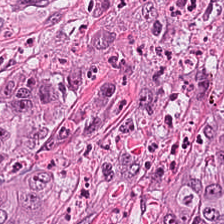

In [144]:
idx = 930
load_image(paths, idx)

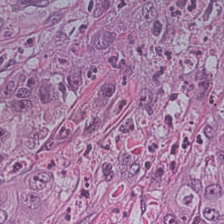

In [145]:
aug = fr.FatAugmentation(scale=30, keep_ignorred=True)
load_image(paths, idx, aug)

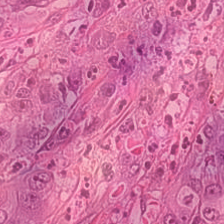

In [146]:
aug = fr.SquamousAugmentation(scale=10, keep_ignorred=True)
load_image(paths, idx, aug)

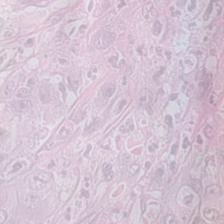

In [147]:
aug = fr.ThreadAugmentation(scale=10, keep_ignorred=True)
load_image(paths, idx, aug)

<tifffile.TiffFile 'TCGA-AN-A0G0-DX…MPP-0.2300_1.tif'> shaped series shape does not match page shape
<tifffile.TiffFile 'TCGA-AC-A2QH-DX…9_MPP-0.2300.tif'> shaped series shape does not match page shape
<tifffile.TiffFile 'TCGA-AC-A2QH-DX1…P-01.2300_1.tif'> shaped series shape does not match page shape
<tifffile.TiffFile 'TCGA-EW-A1P8-DX1…MPP-0.23001.tif'> shaped series shape does not match page shape
<tifffile.TiffFile 'TCGA-AN-A0AL-DX…MPP-0.2300_1.tif'> shaped series shape does not match page shape
<tifffile.TiffFile 'TCGA-AC-A2QH-DX1…P-01.2300_2.tif'> shaped series shape does not match page shape
<tifffile.TiffFile 'TCGA-AC-A2QH-DX1…P-01.2300_1.tif'> shaped series shape does not match page shape
<tifffile.TiffFile 'TCGA-AC-A2QH-DX…9_MPP-0.2300.tif'> shaped series shape does not match page shape
<tifffile.TiffFile 'TCGA-EW-A1P8-DX…MPP-0.2300_2.tif'> shaped series shape does not match page shape
<tifffile.TiffFile 'TCGA-AN-A0AL-DX…MPP-0.2300_1.tif'> shaped series shape does not match p

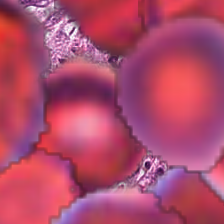

In [148]:
aug = fr.BloodCellAugmentation(scale=5, keep_ignorred=True)
load_image(paths, idx, aug)

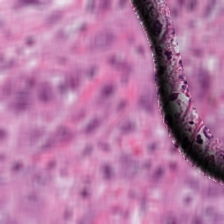

In [149]:
aug = fr.BubbleAugmentation(base_augmentation=torchvision.transforms.GaussianBlur(kernel_size=(9, 9),sigma=10))
aug.overlay_h = 700
aug.overlay_w = 700
load_image(paths, idx, aug)

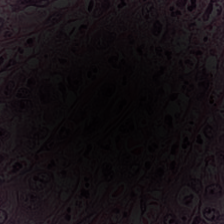

In [150]:
aug = fr.DarkSpotsAugmentation(scale=5,keep_ignorred=True)
load_image(paths, idx, aug)

## Cosine test

In [62]:
import torch
import torchvision
import os
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm.auto import tqdm


root_dir = "../new-paradigm/new-10-client-1-server-10-untrained-Adam/models"
path = Path(root_dir)
client_paths = [path/f"client-{i}" for i in range(8)]
server_path = path/"server"
distribution_clients = [0,1,2,3,4,5,6,7]
test_clients = [0,1,2,3,4,5,6,7]
server_path = path/"server"
_,_,files = next(os.walk(client_paths[0]))
num_epochs = len(files)
device1 = "cuda:0" if torch.cuda.is_available() else 'cpu'
device2 = "cuda:0" if torch.cuda.is_available() else 'cpu'
# pca_percent_variation = 0.95


class CosineSimilarity:
    def __init__(self, device1, device2):
        self.device1 = device1
        self.device2 = device2

    def _cosineSimilarity(self, x, y):
        # print(cov.shape)
        x = x/torch.norm(x, dim = 1).reshape(-1, 1)
        y = y/torch.norm(y, dim = 1).reshape(-1, 1)
        return torch.mm(x, y.T)

    def cosineDistance(self, test_data, train_data):
        train_data = train_data.to(self.device1)
        test_data = test_data.to(self.device1)
        
        return 1-self._cosineSimilarity(test_data, train_data)
    
    
    def pca_transform(self, train_data, test_data, percent_variation):
        if torch.is_tensor(train_data):
            train_data = train_data.to('cpu').numpy()
        if torch.is_tensor(test_data):
            test_data = test_data.to('cpu').numpy()

        scalar = StandardScaler()
        scalar.fit(train_data)
        train_data = scalar.transform(train_data)
        test_data = scalar.transform(test_data)

        pca = PCA(percent_variation)
        pca.fit(train_data)
        train_data = pca.transform(train_data)
        test_data = pca.transform(test_data)

        train_data = torch.tensor(train_data).to(self.device1)
        test_data = torch.tensor(test_data).to(self.device2)

        return train_data, test_data, pca


fin_cosine = {}
for epoch in range(1, num_epochs):
    client_models = [torch.load(client_paths[i]/f"epoch-{epoch}.pt", map_location='cpu') for i in range(len(client_paths))]            
    prev_server_model = torch.load(server_path/f"epoch-{epoch-1}.pt", map_location='cpu')
    keys = list(prev_server_model.keys())
    cosine_dis = {}
    for key in keys[1:]:
        if "conv" not in key:
            continue
        
        cosine_dis[key] = {}
        

        for i in range(len(client_models)):
            client_models[i][key] = client_models[i][key] - prev_server_model[key]

        temp_m = {}
        used_channels = 0
        for in_channel in range(client_models[0][key].shape[1]):
            try:
                train_data, test_data = [], []

                num_samples_per_client = client_models[0][key].shape[0]

                for i in distribution_clients:
                    train_data.extend(client_models[i][key][:,in_channel].unsqueeze(dim=1).numpy())

                for i in test_clients:
                    test_data.extend(client_models[i][key][:,in_channel].unsqueeze(dim=1).numpy())
                    
                        
                train_data = np.array(train_data).astype(np.float64)
                test_data = np.array(test_data).astype(np.float64)
                

                
                train_data = train_data.reshape(train_data.shape[0], -1)
                test_data = test_data.reshape(test_data.shape[0], -1)
                # print(train_data.shape, end = " ")
                m = CosineSimilarity(device1, device2)

                # train_data, test_data, pca = m.pca_transform(train_data=train_data, test_data=test_data, percent_variation=pca_percent_variation)
                train_data, test_data = torch.tensor(train_data), torch.tensor(test_data)
                # print(key)
                # print(train_data.shape, test_data.shape)
                # print(pca.n_components_)
                # print(train_data.shape, test_data.shape)
                cosineDis = m.cosineDistance(test_data, train_data)
                cosineDis = cosineDis.sum(dim = 1)/cosineDis.shape[1]

                # print(key, mahal)

                

                # for (key, value) in mahal:
                #     if key in temp_m.keys():
                #         temp_m[key] += value
                #     else:
                #         temp_m[key] = value
                # temp = mahal.shape

                temp = cosineDis
                
                for i in range(len(test_clients)):
                    client = test_clients[i]
                    if i in temp_m.keys():
                        # print(key)
                        temp_m[client] += torch.sum(cosineDis[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
                    else:
                        temp_m[client] = torch.sum(cosineDis[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
                
                used_channels += 1
            except:
                # print(key, in_channel)
                continue
            # break
       
        # print(used_channels, client_models[0][key].shape[1])

        for (i, j) in temp_m.items():
            cosine_dis[key][i] = j/used_channels
        
    fin_cosine[epoch] = cosine_dis
    break

In [63]:
fin_cosine

{1: {'features.denseblock1.denselayer1.conv1.weight': {0: nan,
   1: nan,
   2: nan,
   3: nan,
   4: nan,
   5: nan,
   6: nan,
   7: nan},
  'features.denseblock1.denselayer1.conv2.weight': {0: nan,
   1: nan,
   2: nan,
   3: nan,
   4: nan,
   5: nan,
   6: nan,
   7: nan},
  'features.denseblock1.denselayer2.conv1.weight': {0: nan,
   1: nan,
   2: nan,
   3: nan,
   4: nan,
   5: nan,
   6: nan,
   7: nan},
  'features.denseblock1.denselayer2.conv2.weight': {0: nan,
   1: nan,
   2: nan,
   3: nan,
   4: nan,
   5: nan,
   6: nan,
   7: nan},
  'features.denseblock1.denselayer3.conv1.weight': {0: nan,
   1: nan,
   2: nan,
   3: nan,
   4: nan,
   5: nan,
   6: nan,
   7: nan},
  'features.denseblock1.denselayer3.conv2.weight': {0: nan,
   1: nan,
   2: nan,
   3: nan,
   4: nan,
   5: nan,
   6: nan,
   7: nan},
  'features.denseblock1.denselayer4.conv1.weight': {0: nan,
   1: nan,
   2: nan,
   3: nan,
   4: nan,
   5: nan,
   6: nan,
   7: nan},
  'features.denseblock1.densela

In [32]:
x, y = torch.tensor([[0.0, 2.0], [2.0, 0], [1.0, 3.0]]), torch.tensor([[0.0, 1.0], [1.0, 0.0]])
1 - _cosineSimilarity(x, y)

tensor([[0.0000, 1.0000],
        [1.0000, 0.0000],
        [0.0513, 0.6838]])

In [28]:
torch.norm(x, dim=1)

tensor([2.0000, 2.0000, 3.1623])

## Euclid

In [12]:
import torch
import torchvision
import os
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm.auto import tqdm


root_dir = "../new-paradigm/new-10-client-1-server-10-ood-2-severe-untrained-Adam/models"
path = Path(root_dir)
client_paths = [path/f"client-{i}" for i in range(8)]
server_path = path/"server"
distribution_clients = [0,1,2,3,4,5,6,7]
test_clients = [0,1,2,3,4,5,6,7]
server_path = path/"server"
_,_,files = next(os.walk(client_paths[0]))
num_epochs = len(files)
device1 = "cuda:0" if torch.cuda.is_available() else 'cpu'
device2 = "cuda:0" if torch.cuda.is_available() else 'cpu'
# pca_percent_variation = 0.95


class EuclidianDistance:
    def __init__(self, device1, device2):
        self.device1 = device1
        self.device2 = device2

    def euclidianDistance(self, test_data, train_data):
        train_data = train_data.to(self.device1)
        test_data = test_data.to(self.device1)
        n, m = test_data.shape[0], train_data.shape[0]
        train_data = train_data.unsqueeze(1).expand(-1, m, -1)
        test_data = test_data.unsqueeze(0).expand(n, -1, -1)
        squared_diff = (train_data - test_data) ** 2
        euclidean_distances = torch.sqrt(squared_diff.sum(dim=2))
        return euclidean_distances
    
    
    def pca_transform(self, train_data, test_data, percent_variation):
        if torch.is_tensor(train_data):
            train_data = train_data.to('cpu').numpy()
        if torch.is_tensor(test_data):
            test_data = test_data.to('cpu').numpy()

        scalar = StandardScaler()
        scalar.fit(train_data)
        train_data = scalar.transform(train_data)
        test_data = scalar.transform(test_data)

        pca = PCA(percent_variation)
        pca.fit(train_data)
        train_data = pca.transform(train_data)
        test_data = pca.transform(test_data)

        train_data = torch.tensor(train_data).to(self.device1)
        test_data = torch.tensor(test_data).to(self.device2)

        return train_data, test_data, pca


fin_euclid = {}
for epoch in range(1, num_epochs):
    client_models = [torch.load(client_paths[i]/f"epoch-{epoch}.pt", map_location='cpu') for i in range(len(client_paths))]            
    prev_server_model = torch.load(server_path/f"epoch-{epoch-1}.pt", map_location='cpu')
    keys = list(prev_server_model.keys())
    euclid_dis = {}
    for key in keys:
        if "conv" not in key:
            continue
        
        euclid_dis[key] = {}
        

        for i in range(len(client_models)):
            client_models[i][key] = client_models[i][key] - prev_server_model[key]

        temp_m = {}
        used_channels = 0
        for in_channel in range(client_models[0][key].shape[1]):
                train_data, test_data = [], []

                num_samples_per_client = client_models[0][key].shape[0]

                for i in distribution_clients:
                    train_data.extend(client_models[i][key][:,in_channel].unsqueeze(dim=1).numpy())

                for i in test_clients:
                    test_data.extend(client_models[i][key][:,in_channel].unsqueeze(dim=1).numpy())
                    
                        
                train_data = np.array(train_data).astype(np.float64)
                test_data = np.array(test_data).astype(np.float64)
                

                
                train_data = train_data.reshape(train_data.shape[0], -1)
                test_data = test_data.reshape(test_data.shape[0], -1)
                # print(train_data.shape, end = " ")
                m = EuclidianDistance(device1, device2)

                # train_data, test_data, pca = m.pca_transform(train_data=train_data, test_data=test_data, percent_variation=pca_percent_variation)
                train_data, test_data = torch.tensor(train_data), torch.tensor(test_data)
                # print(key)
                # print(train_data.shape, test_data.shape)
                # print(pca.n_components_)
                # print(train_data.shape, test_data.shape)
                euclidDis = m.euclidianDistance(test_data, train_data)
                euclidDis = euclidDis.sum(dim = 0)/euclidDis.shape[1]

                # print(key, mahal)

                

                # for (key, value) in mahal:
                #     if key in temp_m.keys():
                #         temp_m[key] += value
                #     else:
                #         temp_m[key] = value
                # temp = mahal.shape

                for i in range(len(test_clients)):
                    client = test_clients[i]
                    if i in temp_m.keys():
                        # print(key)
                        temp_m[client] += torch.sum(euclidDis[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
                    else:
                        temp_m[client] = torch.sum(euclidDis[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
                
                used_channels += 1

        # print(used_channels, client_models[0][key].shape[1])

        for (i, j) in temp_m.items():
            euclid_dis[key][i] = j/used_channels
        # break

    fin_euclid[epoch] = euclid_dis
    break


In [13]:
fin_euclid

{1: {'features.conv0.weight': {0: 0.06993718154802842,
   1: 0.0693393517392835,
   2: 0.07433979944405174,
   3: 0.07041730996370298,
   4: 0.07042355133986826,
   5: 0.07112806930235431,
   6: 0.07836949980975551,
   7: 0.06951566364063162},
  'features.denseblock1.denselayer1.conv1.weight': {0: 0.012722875231014737,
   1: 0.012701168521015183,
   2: 0.013692578115974833,
   3: 0.013439001844554686,
   4: 0.012998729954747466,
   5: 0.012812668852047192,
   6: 0.012756180260920904,
   7: 0.011434400152798252},
  'features.denseblock1.denselayer1.conv2.weight': {0: 0.05323857187003795,
   1: 0.05315752997945391,
   2: 0.05154608266310014,
   3: 0.05117990929452657,
   4: 0.050855956146810155,
   5: 0.05482550195921447,
   6: 0.04942558503584802,
   7: 0.04339399859386789},
  'features.denseblock1.denselayer2.conv1.weight': {0: 0.011843964390353163,
   1: 0.01139387752414041,
   2: 0.011934898840187792,
   3: 0.011808695337321784,
   4: 0.011542827291810734,
   5: 0.011549302398652974,

In [15]:
x = torch.tensor([[1,2], [3,4], [1,2]])
y = torch.tensor([[-2,-2], [0,0]])
m = EuclidianDistance(device1, device1)
m.euclidianDistance(x, y)

RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 1

In [11]:
x = torch.tensor([[1,2], [3,4]])
y = torch.tensor([[-2,-2], [0,0]])
m = EuclidianDistance(device1, device1)
m.euclidianDistance(x, y)

tensor([[5.0000, 7.8102],
        [2.2361, 5.0000]], device='cuda:0')

In [1]:
import torch
l = torch.load("../new-paradigm/new-10-client-1-server-10-ood-2-severe-untrained-Adam/models/server/epoch-0.pt", map_location = 'cpu')

In [8]:
for (key, value) in l.items():
    print(value.shape)

torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([])
torch.Size([128, 64, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([])
torch.Size([32, 128, 3, 3])
torch.Size([96])
torch.Size([96])
torch.Size([96])
torch.Size([96])
torch.Size([])
torch.Size([128, 96, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([])
torch.Size([32, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([])
torch.Size([128, 128, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([])
torch.Size([32, 128, 3, 3])
torch.Size([160])
torch.Size([160])
torch.Size([160])
torch.Size([160])
torch.Size([])
torch.Size([128, 160, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([])
torch

## LFG

In [3]:
import torch
import torchvision
import os
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm.auto import tqdm


root_dir = "../new-paradigm/new-10-client-1-server-10-ood-2-severe-untrained-Adam/models"
path = Path(root_dir)
client_paths = [path/f"client-{i}" for i in range(8)]
server_path = path/"server"
distribution_clients = [0,1,2,3,4,5,6,7]
test_clients = [0,1,2,3,4,5,6,7]
server_path = path/"server"
_,_,files = next(os.walk(client_paths[0]))
num_epochs = len(files)
device1 = "cuda:0" if torch.cuda.is_available() else 'cpu'
device2 = "cuda:0" if torch.cuda.is_available() else 'cpu'
# pca_percent_variation = 0.95


class MahalanobisDistance:
    def __init__(self, device1, device2):
        self.device1 = device1
        self.device2 = device2

    def _mahalanobis(self, x_test, x_mean, cov, device):
        # print(cov.shape)
        cov2 = cov.to(device)
        L = torch.linalg.cholesky(cov2)
        test_data = ((x_test - x_mean.unsqueeze(0))).to(device)
        mdis = torch.linalg.solve(L, test_data.T)
        return torch.linalg.norm(mdis, dim=0)
    
    def _mahalanobis_approx(self, x_test, x_mean, cov, device):
        cov2 = cov.to(device)
        test_data = ((x_test - x_mean.unsqueeze(0))).to(device)
        return torch.mm(test_data, torch.mm(torch.linalg.pinv(cov2), test_data.T))

    def mahalanobis(self, train_data, test_data):
        train_data = train_data.to(self.device1)
        test_data = test_data.to(self.device1)
        train_mean = torch.mean(train_data, dim=0)
        
        train_cov = torch.cov(train_data.T)
        if(train_cov.shape == torch.Size([])):
            train_cov = train_cov.reshape(1,1)
        
        return self._mahalanobis(test_data, train_mean, train_cov, self.device2)
    
    def mahalanobis_approx(self, train_data, test_data):
        train_data = train_data.to(self.device1)
        test_data = test_data.to(self.device1)
        train_mean = torch.mean(train_data, dim=0)
        train_cov = torch.cov(train_data.T)
        if(train_cov.shape == torch.Size([])):
            train_cov = train_cov.reshape(1,1)
        return self._mahalanobis_approx(test_data, train_mean, train_cov, self.device2)
    
    def pca_transform(self, train_data, test_data, percent_variation):
        if torch.is_tensor(train_data):
            train_data = train_data.to('cpu').numpy()
        if torch.is_tensor(test_data):
            test_data = test_data.to('cpu').numpy()

        scalar = StandardScaler()
        scalar.fit(train_data)
        train_data = scalar.transform(train_data)
        test_data = scalar.transform(test_data)

        pca = PCA(percent_variation)
        pca.fit(train_data)
        train_data = pca.transform(train_data)
        test_data = pca.transform(test_data)

        train_data = torch.tensor(train_data).to(self.device1)
        test_data = torch.tensor(test_data).to(self.device2)

        return train_data, test_data, pca


In [9]:
fin_mahal = {}
for epoch in range(1,2):
    client_models = [torch.load(client_paths[i]/f"epoch-{epoch}.pt", map_location='cpu') for i in range(len(client_paths))]            
    prev_server_model = torch.load(server_path/f"epoch-{epoch-1}.pt", map_location='cpu')
    keys = list(prev_server_model.keys())
    mahal_dis = {}
    for key in keys:
        
        
        mahal_dis[key] = {}

        for i in range(len(client_models)):
            client_models[i][key] = client_models[i][key] - prev_server_model[key]

        temp_m = {}
        used_channels = 0
        try:
            train_data, test_data = [], []

            num_samples_per_client = torch.numel(client_models[0][key])

            for i in distribution_clients:
                train_data.extend(client_models[i][key].numpy())

            for i in test_clients:
                test_data.extend(client_models[i][key].numpy())
                
                    
            train_data = np.array(train_data).astype(np.float64)
            test_data = np.array(test_data).astype(np.float64)
            

            
            train_data = train_data.reshape(-1, 1)
            test_data = test_data.reshape(-1, 1)
            # print(train_data.shape, end = " ")
            m = MahalanobisDistance(device1, device2)

            # train_data, test_data, pca = m.pca_transform(train_data=train_data, test_data=test_data, percent_variation=pca_percent_variation)
            train_data, test_data = torch.tensor(train_data), torch.tensor(test_data)
            # print(train_data.shape, test_data.shape)
            # print(key)
            # print(train_data.shape, test_data.shape)
            # print(pca.n_components_)
            # print(train_data.shape, test_data.shape)
            mahal = m.mahalanobis(train_data, test_data)

            # print(key, mahal)

            

            # for (key, value) in mahal:
            #     if key in temp_m.keys():
            #         temp_m[key] += value
            #     else:
            #         temp_m[key] = value
            # temp = mahal.shape

            for i in range(len(test_clients)):
                client = test_clients[i]
                if i in temp_m.keys():
                    # print(key)
                    temp_m[client] += torch.sum(mahal[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
                else:
                    temp_m[client] = torch.sum(mahal[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
            
            used_channels += 1
            print(key)
        except:
            # break
            continue
            # break

        # print(used_channels, client_models[0][key].shape[1])

        for (i, j) in temp_m.items():
            mahal_dis[key][i] = j/used_channels

    fin_mahal[epoch] = mahal_dis
    # break


features.conv0.weight
features.norm0.weight
features.norm0.bias
features.denseblock1.denselayer1.norm1.weight
features.denseblock1.denselayer1.norm1.bias
features.denseblock1.denselayer1.conv1.weight
features.denseblock1.denselayer1.norm2.weight
features.denseblock1.denselayer1.norm2.bias
features.denseblock1.denselayer1.conv2.weight
features.denseblock1.denselayer2.norm1.weight
features.denseblock1.denselayer2.norm1.bias
features.denseblock1.denselayer2.conv1.weight
features.denseblock1.denselayer2.norm2.weight
features.denseblock1.denselayer2.norm2.bias
features.denseblock1.denselayer2.conv2.weight
features.denseblock1.denselayer3.norm1.weight
features.denseblock1.denselayer3.norm1.bias
features.denseblock1.denselayer3.conv1.weight
features.denseblock1.denselayer3.norm2.weight
features.denseblock1.denselayer3.norm2.bias
features.denseblock1.denselayer3.conv2.weight
features.denseblock1.denselayer4.norm1.weight
features.denseblock1.denselayer4.norm1.bias
features.denseblock1.denselaye

In [8]:
import torch
l = torch.load(f = "../new-paradigm/new-10-client-1-server-10-ana-75-untrained-Adam/mahal_dis_all_distribution_inchannelwise.pt", map_location = 'cpu')

In [6]:
l[5]

{'features.conv0.weight': {0: 4.689547425761766,
  1: 4.449797816370945,
  2: 4.172641686746793,
  3: 4.864165825642856,
  4: 4.236500732645294,
  5: 4.717774348314372,
  6: 3.383384172691265,
  7: 4.029856094375302},
 'features.denseblock1.denselayer1.conv1.weight': {0: 0.7122521535255132,
  1: 0.61932891405337,
  2: 0.5643462408840841,
  3: 0.6331895936140288,
  4: 0.5910665387040731,
  5: 0.5912015865582132,
  6: 0.7187652717818266,
  7: 0.8655939967099153},
 'features.denseblock1.denselayer1.conv2.weight': {0: 2.2597642652215355,
  1: 2.459226650698954,
  2: 2.37203990936021,
  3: 2.508667277736276,
  4: 2.318345600668565,
  5: 2.4326909308075013,
  6: 2.0599935846004866,
  7: 2.4056144296921853},
 'features.denseblock1.denselayer2.conv1.weight': {0: 0.6832431512089893,
  1: 0.6454263794207735,
  2: 0.6446606976887176,
  3: 0.6769828773532752,
  4: 0.6024610568515135,
  5: 0.5811292300397077,
  6: 0.8510590831938162,
  7: 0.77182483493054},
 'features.denseblock1.denselayer2.conv2.

In [9]:
for epoch in range(1, len(l)):
    ans = {}
    for(key, value) in l[epoch].items():
        if len(value) == 0:
            continue
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 75.16185508024203, 1: 84.37860069473136, 2: 74.93034375668842, 3: 78.14253750598199, 4: 88.92289516698355, 5: 90.00834791480801, 6: 372.01007726947233, 7: 382.6939101273342}
{0: 79.6047327808241, 1: 79.70779236034657, 2: 89.59423118641753, 3: 77.21992911718937, 4: 91.04735132448515, 5: 89.89271646481531, 6: 376.0927311959221, 7: 364.4716996522267}
{0: 81.11814251303937, 1: 77.80446842134238, 2: 86.44035201256472, 3: 85.93331980401554, 4: 78.88393041142798, 5: 92.68349304924973, 6: 371.7521559038591, 7: 368.7275458086276}
{0: 85.41357151203806, 1: 88.12601854267358, 2: 90.17159522184167, 3: 88.60495075803976, 4: 90.21200277026762, 5: 93.29869658544338, 6: 367.1960238886019, 7: 364.0191676338134}
{0: 86.34458755710568, 1: 82.71023072376734, 2: 86.31628444416403, 3: 84.98543944757243, 4: 84.0677266936249, 5: 84.05475127066073, 6: 369.113523158293, 7: 367.77564294926196}
{0: 84.32019029952103, 1: 81.41416938206712, 2: 83.3151667208518, 3: 82.26697344747144, 4: 83.02535316396605, 5: 80.

In [7]:
for epoch in range(1, len(l)):
    ans = {}
    for(key, value) in l[epoch].items():
        if len(value) == 0:
            continue
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 161.84589020070587, 1: 159.16889041484518, 2: 177.84866203272452, 3: 175.67423500670415, 4: 166.82946032002258, 5: 158.37698964633347, 6: 145.24634272861957, 7: 164.4229588457847}
{0: 141.19037676444572, 1: 173.5263643988298, 2: 144.9402837405289, 3: 173.94119101059698, 4: 155.68181279263246, 5: 138.31343552490966, 6: 152.42605862495088, 7: 162.63822801743132}
{0: 143.38101617130224, 1: 137.98549527005838, 2: 145.07990055604463, 3: 141.71979000516413, 4: 141.49465974970562, 5: 146.19265154403348, 6: 201.5035815639893, 7: 221.0868342568707}
{0: 159.35041401082472, 1: 156.243381421156, 2: 149.89620831852855, 3: 165.37234161083867, 4: 162.4658310542654, 5: 168.03185286821267, 6: 190.2546175460392, 7: 182.1843400270168}
{0: 168.46127613940646, 1: 166.39157406225985, 2: 172.00690489752262, 3: 166.4817716840979, 4: 162.3995540292102, 5: 174.74795218508396, 6: 167.56424450364366, 7: 170.0483684634043}
{0: 180.67055004015268, 1: 159.83560621135, 2: 165.89783418994207, 3: 179.21294077535453

In [57]:
import torch
import torchvision
import os
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm.auto import tqdm


root_dir = "../new-paradigm/new-10-client-1-server-10-ood-2-severe-untrained-Adam/models"
path = Path(root_dir)
client_paths = [path/f"client-{i}" for i in range(8)]
server_path = path/"server"
distribution_clients = [0,1,2,3,4,5,6,7]
test_clients = [0,1,2,3,4,5,6,7]
server_path = path/"server"
_,_,files = next(os.walk(client_paths[0]))
num_epochs = len(files)
device1 = "cuda:0" if torch.cuda.is_available() else 'cpu'
device2 = "cuda:0" if torch.cuda.is_available() else 'cpu'
# pca_percent_variation = 0.95


class MahalanobisDistance:
    def __init__(self, device1, device2):
        self.device1 = device1
        self.device2 = device2

    def _mahalanobis(self, x_test, x_mean, cov, device):
        # print(cov.shape)
        cov2 = cov.to(device)
        L = torch.linalg.cholesky(cov2)
        test_data = ((x_test - x_mean.unsqueeze(0))).to(device)
        mdis = torch.linalg.solve(L, test_data.T)
        return torch.linalg.norm(mdis, dim=0)
    
    def _mahalanobis_approx(self, x_test, x_mean, cov, device):
        cov2 = cov.to(device)
        test_data = ((x_test - x_mean.unsqueeze(0))).to(device)
        return torch.mm(test_data, torch.mm(torch.linalg.pinv(cov2), test_data.T))

    def mahalanobis(self, train_data, test_data):
        train_data = train_data.to(self.device1)
        test_data = test_data.to(self.device1)
        train_mean = torch.mean(train_data, dim=0)
        
        train_cov = torch.diag(torch.var(train_data, dim = 0))
        if(train_cov.shape == torch.Size([])):
            train_cov = train_cov.reshape(1,1)
        
        return self._mahalanobis(test_data, train_mean, train_cov, self.device2)
    
    def mahalanobis_approx(self, train_data, test_data):
        train_data = train_data.to(self.device1)
        test_data = test_data.to(self.device1)
        train_mean = torch.mean(train_data, dim=0)
        train_cov = torch.cov(train_data.T)
        if(train_cov.shape == torch.Size([])):
            train_cov = train_cov.reshape(1,1)
        return self._mahalanobis_approx(test_data, train_mean, train_cov, self.device2)
    
    def pca_transform(self, train_data, test_data):
        if torch.is_tensor(train_data):
            train_data = train_data.to('cpu').numpy()
        if torch.is_tensor(test_data):
            test_data = test_data.to('cpu').numpy()

        scalar = StandardScaler()
        scalar.fit(train_data)
        train_data = scalar.transform(train_data)
        test_data = scalar.transform(test_data)

        pca = PCA()
        pca.fit(train_data)
        train_data = pca.transform(train_data)
        test_data = pca.transform(test_data)

        train_data = torch.tensor(train_data).to(self.device1)
        test_data = torch.tensor(test_data).to(self.device2)

        return train_data, test_data, pca


fin_mahal = {}
for epoch in range(1, num_epochs):
    client_models = [torch.load(client_paths[i]/f"epoch-{epoch}.pt", map_location='cpu') for i in range(len(client_paths))]            
    prev_server_model = torch.load(server_path/f"epoch-{epoch-1}.pt", map_location='cpu')
    keys = list(prev_server_model.keys())
    mahal_dis = {}
    for key in keys:
        for i in range(len(client_models)):
            client_models[i][key] = client_models[i][key] - prev_server_model[key]
        if "conv" in key:
        
            mahal_dis[key] = {}
            


            temp_m = {}
            used_channels = 0
            for in_channel in range(client_models[0][key].shape[1]):
                try:
                    train_data, test_data = [], []

                    num_samples_per_client = client_models[0][key].shape[0]

                    for i in distribution_clients:
                        train_data.extend(client_models[i][key][:,in_channel].unsqueeze(dim=1).numpy())

                    for i in test_clients:
                        test_data.extend(client_models[i][key][:,in_channel].unsqueeze(dim=1).numpy())
                        
                            
                    train_data = np.array(train_data).astype(np.float64)
                    test_data = np.array(test_data).astype(np.float64)
                    

                    
                    train_data = train_data.reshape(train_data.shape[0], -1)
                    test_data = test_data.reshape(test_data.shape[0], -1)
                    # print(train_data.shape, end = " ")
                    m = MahalanobisDistance(device1, device2)

                    train_data, test_data, pca = m.pca_transform(train_data=train_data, test_data=test_data)
                    # train_data, test_data = torch.tensor(train_data), torch.tensor(test_data)
                    # print(key)
                    # print(train_data.shape, test_data.shape)
                    # print(pca.n_components_)
                    # print(train_data.shape, test_data.shape)
                    mahal = m.mahalanobis(train_data, test_data)

                    # print(key, mahal)

                    

                    # for (key, value) in mahal:
                    #     if key in temp_m.keys():
                    #         temp_m[key] += value
                    #     else:
                    #         temp_m[key] = value
                    # temp = mahal.shape

                    for i in range(len(test_clients)):
                        client = test_clients[i]
                        if i in temp_m.keys():
                            # print(key)
                            temp_m[client] += torch.sum(mahal[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
                        else:
                            temp_m[client] = torch.sum(mahal[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
                    
                    used_channels += 1
                except:
                    # print(key, in_channel)
                    continue
                # break

            # print(used_channels, client_models[0][key].shape[1])

            for (i, j) in temp_m.items():
                mahal_dis[key][i] = j/used_channels
        
        else:
            mahal_dis[key] = {}

            temp_m = {}
            used_channels = 0
            try:
                train_data, test_data = [], []

                num_samples_per_client = 1
                

                for i in distribution_clients:
                    train_data.extend(client_models[i][key].reshape(1, -1).numpy())

                for i in test_clients:
                    test_data.extend(client_models[i][key].reshape(1, -1).numpy())
                    
                        
                train_data = np.array(train_data).astype(np.float64)
                test_data = np.array(test_data).astype(np.float64)
                

                
                # print(train_data.shape, end = " ")
                m = MahalanobisDistance(device1, device2)

                train_data, test_data, pca = m.pca_transform(train_data=train_data, test_data=test_data)
                # train_data, test_data = torch.tensor(train_data), torch.tensor(test_data)
                # print(key)
                # print(train_data.shape, test_data.shape)
                # print(pca.n_components_)
                # print(train_data.shape, test_data.shape)
                mahal = m.mahalanobis(train_data, test_data)

                # print(key, mahal)

                

                # for (key, value) in mahal:
                #     if key in temp_m.keys():
                #         temp_m[key] += value
                #     else:
                #         temp_m[key] = value
                # temp = mahal.shape

                for i in range(len(test_clients)):
                    client = test_clients[i]
                    if i in temp_m.keys():
                        # print(key)
                        temp_m[client] += torch.sum(mahal[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
                    else:
                        temp_m[client] = torch.sum(mahal[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
                
                # used_channels += 1
            except:
                # print(key, in_channel)
                continue
                # break

            # print(used_channels, client_models[0][key].shape[1])

            for (i, j) in temp_m.items():
                mahal_dis[key][i] = j


    fin_mahal[epoch] = mahal_dis
    # break

/gris/gris-f/homelv/adatta/miniconda3/envs/pytorchenv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/gris/gris-f/homelv/adatta/miniconda3/envs/pytorchenv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/gris/gris-f/homelv/adatta/miniconda3/envs/pytorchenv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/gris/gris-f/homelv/adatta/miniconda3/envs/pytorchenv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/gris/gris-f/homelv/adatta/miniconda3/envs/pytorchenv/lib/python3.8/site-pac

/gris/gris-f/homelv/adatta/miniconda3/envs/pytorchenv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/gris/gris-f/homelv/adatta/miniconda3/envs/pytorchenv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/gris/gris-f/homelv/adatta/miniconda3/envs/pytorchenv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/gris/gris-f/homelv/adatta/miniconda3/envs/pytorchenv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/gris/gris-f/homelv/adatta/miniconda3/envs/pytorchenv/lib/python3.8/site-pac

In [4]:
fin_mahal

{1: {'features.conv0.weight': {0: 5.386093422731105,
   1: 5.358810601327931,
   2: 5.805700414758604,
   3: 5.6859600681005285,
   4: 5.546270296840156,
   5: 5.726576235452338,
   6: 5.635243057282415,
   7: 2.764129596877606},
  'features.norm0.weight': {},
  'features.norm0.bias': {0: 2.4748737341529163,
   1: 2.4748737341529163,
   2: 2.474873734152917,
   3: 2.4748737341529154,
   4: 2.4748737341529163,
   5: 2.4748737341529163,
   6: 2.4748737341529163,
   7: 2.474873734152916},
  'features.norm0.running_mean': {},
  'features.norm0.running_var': {},
  'features.norm0.num_batches_tracked': {},
  'features.denseblock1.denselayer1.norm1.weight': {0: 2.4748737341529163,
   1: 2.4748737341529163,
   2: 2.4748737341529163,
   3: 2.4748737341529163,
   4: 2.4748737341529163,
   5: 2.4748737341529163,
   6: 2.474873734152917,
   7: 2.4748737341529163},
  'features.denseblock1.denselayer1.norm1.bias': {},
  'features.denseblock1.denselayer1.norm1.running_mean': {},
  'features.densebloc

In [5]:
key = 'features.denseblock4.denselayer8.norm1.weight'
for i in range(len(client_models)):
            client_models[i][key] = client_models[i][key] - prev_server_model[key]

In [6]:
key = 'features.denseblock4.denselayer8.norm1.weight'
for i in range(len(client_models)):
            client_models[i][key] = client_models[i][key] - prev_server_model[key]
train_data, test_data = [], []

num_samples_per_client = 1


for i in distribution_clients:
    train_data.extend(client_models[i][key].reshape(1, -1).numpy())

for i in test_clients:
    test_data.extend(client_models[i][key].reshape(1, -1).numpy())
    
        
train_data = np.array(train_data).astype(np.float64)
test_data = np.array(test_data).astype(np.float64)


In [12]:
m = MahalanobisDistance(device1, device2)
tr, te, pca = m.pca_transform(train_data, test_data)

In [27]:
tr[]

tensor([[-1.9544e+00,  7.7915e+00,  1.5988e+01, -1.3275e+01, -3.3296e+00,
          1.2189e+00, -5.9912e+00,  7.7531e-16],
        [-3.1384e+00, -6.0308e+00,  5.2226e+00,  5.8927e-01, -1.8538e+00,
          1.0534e+01,  1.0463e+01,  7.6704e-17],
        [-1.2925e+01, -1.6263e+00,  2.1840e+00,  1.5431e+01, -1.1005e+01,
         -1.8129e+00, -4.3621e+00, -1.3438e-15],
        [-8.8774e+00, -6.8061e+00, -1.1022e+01, -1.1233e+01, -5.6564e+00,
         -8.6006e+00,  4.5351e+00, -1.1767e-15],
        [-5.7261e-01,  6.0834e+00,  9.0877e+00,  6.3775e+00,  1.3000e+01,
         -8.4495e+00,  4.4907e+00,  4.1670e-15],
        [-1.2429e+01, -4.4567e+00, -1.0601e+01, -1.1782e+00,  1.2061e+01,
          5.9262e+00, -6.5931e+00, -4.5204e-15],
        [ 2.5759e+01, -1.7931e+01,  4.2949e-01,  1.5634e+00, -1.6945e-01,
         -1.0551e+00, -3.3065e+00,  5.1422e-15],
        [ 1.4138e+01,  2.2976e+01, -1.1289e+01,  1.7243e+00, -3.0469e+00,
          2.2389e+00,  7.6435e-01, -2.7446e-15]], device='cuda:0'

In [34]:
cv = torch.diag(torch.var(tr, dim=0))

In [45]:
torch.inverse(torch.cov(tr.T))@torch.cov(tr.T)

tensor([[ 1.2598e+00, -2.3447e-01,  3.9645e-01,  3.2101e-02,  9.3942e-02,
         -1.4742e-01,  3.5596e-02,  1.0814e-16],
        [ 1.4495e-01,  1.0052e+00, -1.2270e-01, -3.3330e-02, -7.4853e-02,
          1.0092e-01, -1.1445e-02, -4.9245e-17],
        [ 1.1995e-01, -1.5345e-01,  9.9826e-01,  3.9245e-02,  4.3533e-02,
         -1.1852e-01,  9.6765e-03,  1.4458e-16],
        [ 6.1524e-02, -7.4260e-02,  6.9374e-02,  1.0053e+00,  2.6736e-03,
         -2.8581e-02,  1.1954e-02,  2.8406e-17],
        [ 5.9862e-02, -2.2655e-02,  1.7192e-01,  5.6406e-03,  1.0342e+00,
         -2.1189e-02,  8.6748e-03,  3.4413e-17],
        [ 1.7386e-01,  2.1531e-01, -3.3062e-02, -3.7655e-02, -6.4599e-02,
          1.1306e+00, -1.3142e-03, -8.0133e-17],
        [ 8.6841e-02, -4.5471e-02,  1.0728e-01,  7.3130e-03,  3.6007e-02,
         -6.3986e-02,  9.9780e-01,  1.1301e-16],
        [-5.1015e+13,  2.6270e+15, -1.9832e+15, -1.6393e+14, -4.5920e+14,
          4.5440e+14,  1.6431e+13,  4.9066e-01]], device='cuda:0'

In [46]:
torch.inverse(cv)@torch.cov(tr.T)

tensor([[ 1.0000e+00,  3.8110e-16,  1.8040e-16,  2.6538e-16, -2.6457e-16,
          1.4097e-18,  3.5675e-17,  1.3579e-16],
        [ 4.6273e-16,  1.0000e+00,  3.0995e-16,  1.7437e-16,  1.1915e-16,
         -1.9664e-16, -5.1458e-16, -8.9323e-17],
        [ 3.1502e-16,  4.4575e-16,  1.0000e+00,  1.0549e-15, -1.8210e-16,
         -3.9032e-16,  1.5576e-16,  1.9380e-16],
        [ 5.7634e-16,  3.1189e-16,  1.3120e-15,  1.0000e+00, -2.1001e-16,
         -7.8565e-17, -2.6205e-16,  2.9646e-17],
        [-6.8791e-16,  2.5515e-16, -2.7114e-16, -2.5142e-16,  1.0000e+00,
         -3.1647e-16, -4.6494e-16,  5.2631e-17],
        [ 5.9572e-18, -6.8439e-16, -9.4462e-16, -1.5288e-16, -5.1437e-16,
          1.0000e+00,  7.7059e-16, -1.9599e-16],
        [ 1.7524e-16, -2.0818e-15,  4.3818e-16, -5.9273e-16, -8.7841e-16,
          8.9575e-16,  1.0000e+00,  1.0034e-16],
        [ 2.2965e+15, -1.2441e+15,  1.8770e+15,  2.3086e+14,  3.4234e+14,
         -7.8434e+14,  3.4543e+14,  1.0000e+00]], device='cuda:0'

In [37]:
sad = m._mahalanobis(te, torch.mean(tr, dim=0), cv, device1)

In [50]:
torch.inverse(cv)

tensor([[5.4785e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 6.6520e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 9.5664e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1898e-02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4244e-02, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.3152e-02,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.6912e-02, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 9.2651e+28]], device='cuda:0', dtype=torch.float64)

In [56]:
torch.sqrt(te[0].T @ torch.inverse(cv) @ te[0])

tensor(2.4861, device='cuda:0', dtype=torch.float64)

In [ ]:
torch.linalg.cholesky(cv)

In [28]:
sum(tr[:, 0])/len(tr[0])

tensor(0., device='cuda:0', dtype=torch.float64)

In [38]:
sad

tensor([2.4848, 2.4749, 2.5108, 2.5027, 2.7745, 2.8386, 2.9207, 2.6167],
       device='cuda:0', dtype=torch.float64)

In [ ]:
import torch
import torchvision
import os
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm.auto import tqdm


root_dir = "../new-paradigm/new-10-client-1-server-10-ood-2-severe-untrained-Adam/models"
path = Path(root_dir)
client_paths = [path/f"client-{i}" for i in range(8)]
server_path = path/"server"
distribution_clients = [0,1,2,3,4,5,6,7]
test_clients = [0,1,2,3,4,5,6,7]
server_path = path/"server"
_,_,files = next(os.walk(client_paths[0]))
num_epochs = len(files)
device1 = "cuda:0" if torch.cuda.is_available() else 'cpu'
device2 = "cuda:0" if torch.cuda.is_available() else 'cpu'
# pca_percent_variation = 0.95


class MahalanobisDistance:
    def __init__(self, device1, device2):
        self.device1 = device1
        self.device2 = device2

    def _mahalanobis(self, x_test, x_mean, cov, device):
        # print(cov.shape)
        cov2 = cov.to(device)
        L = torch.linalg.cholesky(cov2)
        test_data = ((x_test - x_mean.unsqueeze(0))).to(device)
        mdis = torch.linalg.solve(L, test_data.T)
        return torch.linalg.norm(mdis, dim=0)
    
    def _mahalanobis_approx(self, x_test, x_mean, cov, device):
        cov2 = cov.to(device)
        test_data = ((x_test - x_mean.unsqueeze(0))).to(device)
        return torch.mm(test_data, torch.mm(torch.linalg.pinv(cov2), test_data.T))

    def mahalanobis(self, train_data, test_data):
        train_data = train_data.to(self.device1)
        test_data = test_data.to(self.device1)
        train_mean = torch.mean(train_data, dim=0)
        
        train_cov = torch.diag(torch.var(train_data, dim = 0))
        if(train_cov.shape == torch.Size([])):
            train_cov = train_cov.reshape(1,1)
        
        return self._mahalanobis(test_data, train_mean, train_cov, self.device2)
    
    def mahalanobis_approx(self, train_data, test_data):
        train_data = train_data.to(self.device1)
        test_data = test_data.to(self.device1)
        train_mean = torch.mean(train_data, dim=0)
        train_cov = torch.diag(torch.mean(train_data, dim=0))
        if(train_cov.shape == torch.Size([])):
            train_cov = train_cov.reshape(1,1)
        return self._mahalanobis_approx(test_data, train_mean, train_cov, self.device2)
    
    def pca_transform(self, train_data, test_data):
        if torch.is_tensor(train_data):
            train_data = train_data.to('cpu').numpy()
        if torch.is_tensor(test_data):
            test_data = test_data.to('cpu').numpy()

        scalar = StandardScaler()
        scalar.fit(train_data)
        train_data = scalar.transform(train_data)
        test_data = scalar.transform(test_data)

        pca = PCA()
        pca.fit(train_data)
        train_data = pca.transform(train_data)
        test_data = pca.transform(test_data)

        train_data = torch.tensor(train_data).to(self.device1)
        test_data = torch.tensor(test_data).to(self.device2)

        return train_data, test_data, pca


fin_mahal = {}
for epoch in range(5, 6):
    client_models = [torch.load(client_paths[i]/f"epoch-{epoch}.pt", map_location='cpu') for i in range(len(client_paths))]            
    prev_server_model = torch.load(server_path/f"epoch-{epoch-1}.pt", map_location='cpu')
    keys = list(prev_server_model.keys())
    mahal_dis = {}
    for key in keys:
        for i in range(len(client_models)):
            client_models[i][key] = client_models[i][key] - prev_server_model[key]
        if "conv" in key:
        
            mahal_dis[key] = {}
            


            temp_m = {}
            used_channels = 0
            for in_channel in range(client_models[0][key].shape[1]):
                try:
                    train_data, test_data = [], []

                    num_samples_per_client = client_models[0][key].shape[0]

                    for i in distribution_clients:
                        train_data.extend(client_models[i][key][:,in_channel].unsqueeze(dim=1).numpy())

                    for i in test_clients:
                        test_data.extend(client_models[i][key][:,in_channel].unsqueeze(dim=1).numpy())
                        
                            
                    train_data = np.array(train_data).astype(np.float64)
                    test_data = np.array(test_data).astype(np.float64)
                    

                    
                    train_data = train_data.reshape(train_data.shape[0], -1)
                    test_data = test_data.reshape(test_data.shape[0], -1)
                    # print(train_data.shape, end = " ")
                    m = MahalanobisDistance(device1, device2)

                    train_data, test_data, pca = m.pca_transform(train_data=train_data, test_data=test_data)
                    # train_data, test_data = torch.tensor(train_data), torch.tensor(test_data)
                    # print(key)
                    # print(train_data.shape, test_data.shape)
                    # print(pca.n_components_)
                    # print(train_data.shape, test_data.shape)
                    mahal = m.mahalanobis(train_data, test_data)

                    # print(key, mahal)

                    

                    # for (key, value) in mahal:
                    #     if key in temp_m.keys():
                    #         temp_m[key] += value
                    #     else:
                    #         temp_m[key] = value
                    # temp = mahal.shape

                    for i in range(len(test_clients)):
                        client = test_clients[i]
                        if i in temp_m.keys():
                            # print(key)
                            temp_m[client] += torch.sum(mahal[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
                        else:
                            temp_m[client] = torch.sum(mahal[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
                    
                    used_channels += 1
                except:
                    # print(key, in_channel)
                    continue
                # break

            # print(used_channels, client_models[0][key].shape[1])

            for (i, j) in temp_m.items():
                mahal_dis[key][i] = j/used_channels
        
        else:
            mahal_dis[key] = {}

            temp_m = {}
            used_channels = 0
            try:
                train_data, test_data = [], []

                num_samples_per_client = 1
                

                for i in distribution_clients:
                    train_data.extend(client_models[i][key].reshape(1, -1).numpy())

                for i in test_clients:
                    test_data.extend(client_models[i][key].reshape(1, -1).numpy())
                    
                        
                train_data = np.array(train_data).astype(np.float64)
                test_data = np.array(test_data).astype(np.float64)
                

                
                # print(train_data.shape, end = " ")
                m = MahalanobisDistance(device1, device2)

                train_data, test_data, pca = m.pca_transform(train_data=train_data, test_data=test_data)
                # train_data, test_data = torch.tensor(train_data), torch.tensor(test_data)
                # print(key)
                # print(train_data.shape, test_data.shape)
                # print(pca.n_components_)
                # print(train_data.shape, test_data.shape)
                mahal = m.mahalanobis(train_data, test_data)

                # print(key, mahal)

                

                # for (key, value) in mahal:
                #     if key in temp_m.keys():
                #         temp_m[key] += value
                #     else:
                #         temp_m[key] = value
                # temp = mahal.shape

                for i in range(len(test_clients)):
                    client = test_clients[i]
                    if i in temp_m.keys():
                        # print(key)
                        temp_m[client] += torch.sum(mahal[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
                    else:
                        temp_m[client] = torch.sum(mahal[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
                
                # used_channels += 1
            except:
                # print(key, in_channel)
                continue
                # break

            # print(used_channels, client_models[0][key].shape[1])

            for (i, j) in temp_m.items():
                mahal_dis[key][i] = j


    fin_mahal[epoch] = mahal_dis
    # break


In [4]:
client_models[0]['features.norm5.running_mean']

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [9]:
fin_mahal

{5: {'features.conv0.weight': {0: 3.468485107231862,
   1: 3.9617198590813243,
   2: 4.046608606456382,
   3: 4.169998233061038,
   4: 3.3714634653951445,
   5: 4.1232846653213615,
   6: 4.4655069732461365,
   7: 5.1597321462133126},
  'features.norm0.weight': {0: 2.5252976828594202,
   1: 2.570173111196664,
   2: 2.5746017345901953,
   3: 3.0818955224586224,
   4: 2.57108593992631,
   5: 2.48231785018952,
   6: 2.5553784408760762,
   7: 2.7546476893371747},
  'features.norm0.bias': {0: 2.4988431470664594,
   1: 2.557965454722094,
   2: 2.9465877961509004,
   3: 2.491360556430258,
   4: 2.913482410808157,
   5: 2.5757113889101286,
   6: 2.5604848790288814,
   7: 2.577709615814023},
  'features.norm0.running_mean': {},
  'features.norm0.running_var': {},
  'features.norm0.num_batches_tracked': {},
  'features.denseblock1.denselayer1.norm1.weight': {0: 2.767927536109018,
   1: 2.7284307723311314,
   2: 2.5903489406907947,
   3: 2.4791680806209184,
   4: 2.7131380818167434,
   5: 2.475571

In [11]:
for epoch in range(5, 6):
    ans = {}
    for(key, value) in fin_mahal[epoch].items():
        if len(value) == 0:
            continue
        if 'conv' in key:
            continue
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

{0: 642.0995616953315, 1: 639.7295477492685, 2: 641.6626622503759, 3: 634.3011991325942, 4: 640.9604263953252, 5: 631.6732772251812, 6: 651.055695983717, 7: 667.7712041007095}


In [18]:
import torch
import torchvision
import os
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm.auto import tqdm


root_dir = "../new-paradigm/new-10-client-1-server-10-ood-2-severe-untrained-Adam/models"
path = Path(root_dir)
client_paths = [path/f"client-{i}" for i in range(8)]
server_path = path/"server"
distribution_clients = [0,1,2,3,4,5,6,7]
test_clients = [0,1,2,3,4,5,6,7]
server_path = path/"server"
_,_,files = next(os.walk(client_paths[0]))
num_epochs = len(files)
# device1 = "cuda:0" if torch.cuda.is_available() else 'cpu'
# device2 = "cuda:0" if torch.cuda.is_available() else 'cpu'
device1 = device2 = 'cpu'
# pca_percent_variation = 0.95

epoch = 1

client_models = [torch.load(client_paths[i]/f"epoch-{epoch}.pt", map_location='cpu') for i in range(len(client_paths))]            
prev_server_model = torch.load(server_path/f"epoch-{epoch-1}.pt", map_location='cpu')


key = 'features.denseblock3.denselayer18.conv2.weight'
for i in range(len(client_models)):
            client_models[i][key] = client_models[i][key] - prev_server_model[key]
train_data, test_data = [], []

num_samples_per_client = 1


for i in distribution_clients:
    train_data.extend(client_models[i][key].numpy())

for i in test_clients:
    test_data.extend(client_models[i][key].numpy())
    
        
train_data = np.array(train_data).astype(np.float64)
test_data = np.array(test_data).astype(np.float64)

In [38]:
train_data.shape

(256, 128, 3, 3)

In [24]:
fs.shape

torch.Size([256, 3, 3])

In [22]:
fs = torch.tensor(train_data[:,0]).to('cpu')

In [43]:
ans = [0.0 for _ in range(8)]
k = train_data.shape[0]/8
for inchannel in range(train_data.shape[1]):
    lm = torch.tensor(train_data[:, inchannel]).reshape(train_data.shape[0], -1).to('cpu')
    for i in range(lm.shape[0]):
        dodo = 0
        for j in range(lm.shape[0]):
            tmp = torch.sqrt(torch.sum(torch.pow(torch.subtract(lm[i].reshape(-1), lm[j].reshape(-1),), 2), dim=0)).item()
            dodo += tmp
        # for j in range(8):
        #     ans[j] += dodo
        idx = int(i//k)
        ans[idx] += dodo/lm.shape[0]

for ddd in range(8):
    ans[ddd] /= train_data.shape[1]

In [42]:
ans

(256, 128, 3, 3)

In [45]:
np.array(ans)/32

array([0.02595276, 0.02419991, 0.0282541 , 0.02571993, 0.02678358,
       0.02344334, 0.02915087, 0.02423058])

In [29]:
torch.sqrt(torch.sum(torch.pow(torch.subtract(fs[0].reshape(-1), fs[1].reshape(-1),), 2), dim=0))

tensor(0.0535, dtype=torch.float64)

In [17]:
for key in prev_server_model.keys():
    if "conv" in key:
        print(key, prev_server_model[key].shape)

features.conv0.weight torch.Size([64, 3, 7, 7])
features.denseblock1.denselayer1.conv1.weight torch.Size([128, 64, 1, 1])
features.denseblock1.denselayer1.conv2.weight torch.Size([32, 128, 3, 3])
features.denseblock1.denselayer2.conv1.weight torch.Size([128, 96, 1, 1])
features.denseblock1.denselayer2.conv2.weight torch.Size([32, 128, 3, 3])
features.denseblock1.denselayer3.conv1.weight torch.Size([128, 128, 1, 1])
features.denseblock1.denselayer3.conv2.weight torch.Size([32, 128, 3, 3])
features.denseblock1.denselayer4.conv1.weight torch.Size([128, 160, 1, 1])
features.denseblock1.denselayer4.conv2.weight torch.Size([32, 128, 3, 3])
features.denseblock1.denselayer5.conv1.weight torch.Size([128, 192, 1, 1])
features.denseblock1.denselayer5.conv2.weight torch.Size([32, 128, 3, 3])
features.denseblock1.denselayer6.conv1.weight torch.Size([128, 224, 1, 1])
features.denseblock1.denselayer6.conv2.weight torch.Size([32, 128, 3, 3])
features.transition1.conv.weight torch.Size([128, 256, 1, 1]

In [26]:
sad = torch.load("../new-paradigm/new-10-client-1-server-10-ood-2-severe-untrained-Adam/euclid_dis_all_distribution_inchannelwise.pt")

In [28]:
sad[1][key]

{0: 0.02595275851840704,
 1: 0.024199906526834195,
 2: 0.02825410234024199,
 3: 0.025719929769727302,
 4: 0.02678357909249202,
 5: 0.02344333815845545,
 6: 0.029150873037826194,
 7: 0.024230581621220753}

## New Stuff 

In [54]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-severe-single-untrained-Adam/mahal_dis_all_pca.pt")
mahal_dis = torch.load(path, map_location='cpu')

for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        if 'conv' in key:
            continue
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

print()
for epoch in range(1, len(mahal_dis)):
    print(list(mahal_dis[epoch].items())[-2:])

{0: 638.7238961202206, 1: 631.4611520170995, 2: 634.131522482365, 3: 636.8696188245337, 4: 628.7889059803217, 5: 638.3303947763923, 6: 674.673204444457, 7: 665.4800261370801}
{0: 642.7764824562624, 1: 632.6441678473244, 2: 637.4351803250499, 3: 633.906422958626, 4: 628.6674561315937, 5: 630.5226610013091, 6: 671.6290955125262, 7: 671.0052056260657}
{0: 1344.9759834269207, 1: 1340.3286876539876, 2: 1335.549470796778, 3: 1334.738921973454, 4: 1335.2618478424306, 5: 1330.6883945722905, 6: 1496.0869034736847, 7: 1521.7235000128494}
{0: 647.1373288901966, 1: 639.0637199866319, 2: 628.2308000565877, 3: 639.5091539065979, 4: 632.4996530367612, 5: 633.0026261137698, 6: 658.4193027741386, 7: 671.2146964108499}
{0: 640.6152999672256, 1: 639.7661960429209, 2: 632.147032730328, 3: 633.9981796005427, 4: 631.7860522914917, 5: 632.1558913414478, 6: 670.8931353532975, 7: 666.7496183445289}
{0: 643.3716178134703, 1: 638.4394360584539, 2: 636.6193123179885, 3: 633.982881505259, 4: 628.6512347126354, 5: 

In [56]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ana-75-untrained-Adam/mahal_dis_all_pca.pt")
mahal_dis = torch.load(path, map_location='cpu')

for epoch in range(1, 1 + len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        if 'conv' in key:
            continue
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

print()
for epoch in range(1, len(mahal_dis)):
    print(list(mahal_dis[epoch].items())[-2:])

{0: 890.7220084118044, 1: 889.2813472114204, 2: 891.9754653270878, 3: 892.093832900978, 4: 889.9288585017813, 5: 886.5679531683993, 6: 2085.3056881895227, 7: 2098.227641718202}
{0: 889.50642302922, 1: 891.4535047520764, 2: 894.6113904132864, 3: 885.6708958783311, 4: 892.2354600573127, 5: 888.6107412270143, 6: 2106.0333513007295, 7: 2089.4686164024865}
{0: 877.3061120373313, 1: 880.3896133126411, 2: 879.5424827845619, 3: 876.524266138975, 4: 876.2205333792085, 5: 879.0291444204016, 6: 2094.882165689606, 7: 2122.7813684634402}
{0: 892.0463867244382, 1: 888.298831674752, 2: 884.853821439631, 3: 884.3074826481076, 4: 887.2854676730304, 5: 888.4663625889816, 6: 2123.7122761899727, 7: 2093.3326706379908}
{0: 883.9438584470656, 1: 889.5429489930099, 2: 884.2768400423525, 3: 885.6580580215847, 4: 881.0082623957464, 5: 881.2331828860292, 6: 2121.769116243535, 7: 2083.580826065609}
{0: 883.6899341729976, 1: 887.7723271762121, 2: 880.2764429605568, 3: 883.535083821481, 4: 882.3874887357315, 5: 87

In [57]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-untrained-Adam/mahal_dis_all_pca.pt")
mahal_dis = torch.load(path, map_location='cpu')

for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        if 'conv' in key:
            continue
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

print()
for epoch in range(1, len(mahal_dis)):
    print(list(mahal_dis[epoch].items())[-2:])

{0: 657.1215901237292, 1: 647.869796080227, 2: 641.7848564424459, 3: 642.5720900309465, 4: 639.9457788412017, 5: 637.7151330667868, 6: 644.0426514713712, 7: 638.241987532901}
{0: 642.6022452632576, 1: 658.2433350201846, 2: 634.1496733083146, 3: 644.5854630386226, 4: 638.4538007207015, 5: 641.9422851039835, 6: 642.0245414415004, 7: 647.1482503726158}
{0: 643.5327088893829, 1: 637.6150913265617, 2: 634.2047893947223, 3: 634.9882661507722, 4: 632.7099920980122, 5: 630.8104924532635, 6: 670.2222746653952, 7: 664.2464983084271}
{0: 642.9112604517032, 1: 637.9744387337163, 2: 640.6280056433544, 3: 641.865766559264, 4: 636.3547951672713, 5: 634.3986446592257, 6: 658.6816873816177, 7: 656.378118748776}
{0: 646.7295042591455, 1: 645.4213465645557, 2: 642.5072249065933, 3: 635.915232799858, 4: 637.9471635459728, 5: 633.7176270888347, 6: 653.2567844270678, 7: 653.2302634656774}
{0: 655.1909729617348, 1: 643.6267846565052, 2: 647.3070261837822, 3: 643.0871136469631, 4: 632.8051730184336, 5: 636.69

In [58]:
import torch
from pathlib import Path

path = Path("../new-paradigm/new-10-client-1-server-10-ood-2-untrained-Adam/mahal_dis_all_pca.pt")
mahal_dis = torch.load(path, map_location='cpu')

for epoch in range(1, len(mahal_dis)):
    ans = {}
    for(key, value) in mahal_dis[epoch].items():
        if 'conv' in key:
            continue
        for (a, b) in value.items():
            if a in ans.keys():
                ans[a] += b
            else:
                ans[a] = b
    
    print(ans)

print()
for epoch in range(1, len(mahal_dis)):
    print(list(mahal_dis[epoch].items())[-2:])

{0: 657.1215901237292, 1: 647.869796080227, 2: 641.7848564424459, 3: 642.5720900309465, 4: 639.9457788412017, 5: 637.7151330667868, 6: 644.0426514713712, 7: 638.241987532901}
{0: 642.6022452632576, 1: 658.2433350201846, 2: 634.1496733083146, 3: 644.5854630386226, 4: 638.4538007207015, 5: 641.9422851039835, 6: 642.0245414415004, 7: 647.1482503726158}
{0: 643.5327088893829, 1: 637.6150913265617, 2: 634.2047893947223, 3: 634.9882661507722, 4: 632.7099920980122, 5: 630.8104924532635, 6: 670.2222746653952, 7: 664.2464983084271}
{0: 642.9112604517032, 1: 637.9744387337163, 2: 640.6280056433544, 3: 641.865766559264, 4: 636.3547951672713, 5: 634.3986446592257, 6: 658.6816873816177, 7: 656.378118748776}
{0: 646.7295042591455, 1: 645.4213465645557, 2: 642.5072249065933, 3: 635.915232799858, 4: 637.9471635459728, 5: 633.7176270888347, 6: 653.2567844270678, 7: 653.2302634656774}
{0: 655.1909729617348, 1: 643.6267846565052, 2: 647.3070261837822, 3: 643.0871136469631, 4: 632.8051730184336, 5: 636.69

## It is what it is

In [1]:
import torch
import torchvision
import os
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm.auto import tqdm


root_dir = "../new-paradigm/new-10-client-1-server-10-ood-2-severe-untrained-Adam/models"
path = Path(root_dir)
client_paths = [path/f"client-{i}" for i in range(8)]
server_path = path/"server"
distribution_clients = [0,1,2,3,4,5,6,7]
test_clients = [0,1,2,3,4,5,6,7]
server_path = path/"server"
_,_,files = next(os.walk(client_paths[0]))
num_epochs = len(files)
device1 = "cuda:0" if torch.cuda.is_available() else 'cpu'
device2 = "cuda:0" if torch.cuda.is_available() else 'cpu'
# pca_percent_variation = 0.95


class CosineSimilarity:
    def __init__(self, device1, device2):
        self.device1 = device1
        self.device2 = device2

    def _cosineSimilarity(self, x, y):
        # print(cov.shape)
        x = x/torch.norm(x, dim = 1).reshape(-1, 1)
        y = y/torch.norm(y, dim = 1).reshape(-1, 1)
        return torch.mm(x, y.T)
    
    def cosineSimilarity(self, test_data, train_data):
        train_data = train_data.to(self.device1)
        test_data = test_data.to(self.device1)
        
        return self._cosineSimilarity(test_data, train_data)
    
    
    def pca_transform(self, train_data, test_data, percent_variation):
        if torch.is_tensor(train_data):
            train_data = train_data.to('cpu').numpy()
        if torch.is_tensor(test_data):
            test_data = test_data.to('cpu').numpy()

        scalar = StandardScaler()
        scalar.fit(train_data)
        train_data = scalar.transform(train_data)
        test_data = scalar.transform(test_data)

        pca = PCA(percent_variation)
        pca.fit(train_data)
        train_data = pca.transform(train_data)
        test_data = pca.transform(test_data)

        train_data = torch.tensor(train_data).to(self.device1)
        test_data = torch.tensor(test_data).to(self.device2)

        return train_data, test_data, pca


fin_cosine = {}
for epoch in range(1, num_epochs):
    client_models = [torch.load(client_paths[i]/f"epoch-{epoch}.pt", map_location='cpu') for i in range(len(client_paths))]            
    prev_server_model = torch.load(server_path/f"epoch-{epoch-1}.pt", map_location='cpu')
    keys = list(prev_server_model.keys())
    cosine_dis = {}
    for key in keys:
        if "conv" not in key:
            continue
        
        cosine_dis[key] = {}
        

        for i in range(len(client_models)):
            client_models[i][key] = client_models[i][key] - prev_server_model[key]

        temp_m = {}
        used_channels = 0
        for in_channel in range(client_models[0][key].shape[1]):
            try:
                train_data, test_data = [], []

                num_samples_per_client = client_models[0][key].shape[0]

                for i in distribution_clients:
                    train_data.extend(client_models[i][key][:,in_channel].unsqueeze(dim=1).numpy())

                for i in test_clients:
                    test_data.extend(client_models[i][key][:,in_channel].unsqueeze(dim=1).numpy())
                    
                        
                train_data = np.array(train_data).astype(np.float64)
                test_data = np.array(test_data).astype(np.float64)
                

                
                train_data = train_data.reshape(train_data.shape[0], -1)
                test_data = test_data.reshape(test_data.shape[0], -1)
                # print(train_data.shape, end = " ")
                m = CosineSimilarity(device1, device2)

                # train_data, test_data, pca = m.pca_transform(train_data=train_data, test_data=test_data, percent_variation=pca_percent_variation)
                train_data, test_data = torch.tensor(train_data), torch.tensor(test_data)
                # print(key)
                # print(train_data.shape, test_data.shape)
                # print(pca.n_components_)
                # print(train_data.shape, test_data.shape)
                cosineDis = m.cosineSimilarity(test_data, train_data)
                cosineDis = cosineDis.sum(dim = 1)/cosineDis.shape[1]

                # print(key, mahal)

                

                # for (key, value) in mahal:
                #     if key in temp_m.keys():
                #         temp_m[key] += value
                #     else:
                #         temp_m[key] = value
                # temp = mahal.shape

                for i in range(len(test_clients)):
                    client = test_clients[i]
                    if i in temp_m.keys():
                        # print(key)
                        temp_m[client] += torch.sum(cosineDis[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
                    else:
                        temp_m[client] = torch.sum(cosineDis[i*num_samples_per_client: (i+1)*num_samples_per_client]).item()/num_samples_per_client
                
                used_channels += 1
            except:
                # print(key, in_channel)
                continue
            # break

        # print(used_channels, client_models[0][key].shape[1])

        for (i, j) in temp_m.items():
            cosine_dis[key][i] = j/used_channels

    fin_cosine[epoch] = cosine_dis
    # break

In [2]:
fin_cosine

{1: {'features.conv0.weight': {0: nan,
   1: nan,
   2: nan,
   3: nan,
   4: nan,
   5: nan,
   6: nan,
   7: nan},
  'features.denseblock1.denselayer1.conv1.weight': {0: nan,
   1: nan,
   2: nan,
   3: nan,
   4: nan,
   5: nan,
   6: nan,
   7: nan},
  'features.denseblock1.denselayer1.conv2.weight': {0: nan,
   1: nan,
   2: nan,
   3: nan,
   4: nan,
   5: nan,
   6: nan,
   7: nan},
  'features.denseblock1.denselayer2.conv1.weight': {0: nan,
   1: nan,
   2: nan,
   3: nan,
   4: nan,
   5: nan,
   6: nan,
   7: nan},
  'features.denseblock1.denselayer2.conv2.weight': {0: nan,
   1: nan,
   2: nan,
   3: nan,
   4: nan,
   5: nan,
   6: nan,
   7: nan},
  'features.denseblock1.denselayer3.conv1.weight': {0: nan,
   1: nan,
   2: nan,
   3: nan,
   4: nan,
   5: nan,
   6: nan,
   7: nan},
  'features.denseblock1.denselayer3.conv2.weight': {0: nan,
   1: nan,
   2: nan,
   3: nan,
   4: nan,
   5: nan,
   6: nan,
   7: nan},
  'features.denseblock1.denselayer4.conv1.weight': {0: 